# Introduction

Understanding the spatial distribution of archaeological sites and artifacts is a fundamental aspect of studying past human activities. However, a significant challenge arises when considering the temporality and chronological uncertainty associated with these points. Not all points we observe in the archaeological record were necessarily contemporaneous, and our chronometric tools for dating them often have significant uncertainties. This complicates traditional point pattern analyses, which typically assume that all points are fixed in both space and time.

ChronoCluster is a Python package designed to address this challenge. It provides tools for analyzing spatial point patterns with temporality and chronological uncertainty, incorporating methods like Ripley's K function and point-wise distance distributions to account for these factors. By allowing for the integration of temporal distributions and uncertainties into spatial analyses, ChronoCluster helps researchers obtain more accurate and meaningful insights from archaeological (and, for that matter, historical and even palaeoclimatic) point data.

Key features of ChronoCluster include:

- Visualization tools for spatial point patterns, including the ability to represent temporal distributions;
- Clustering analysis using Ripley's K, L, and G functions, accounting for temporality (change over time) and chronological uncertainty;
- Pairwise distance distributions accounting for both temporality and chronological uncertainty; and
- Comparison of observed patterns to CSR (Complete Spatial Randomness) baselines to determine significant clustering or dispersion patterns.

In this workbook, you'll be introduced to the package, its paradigm, its terminology, and its key functions and features.

# Spacetime Archaeology

In spatial analysis, a point represents a location of interest within a given study area. In archaeology, points often represent the locations of sites or artifacts. A point pattern is a collection of such points, which can be analyzed to reveal spatial relationships and patterns, such as clustering or dispersion.

Traditional point pattern analyses assume that all points are fixed in both space and time. However, in archaeology, points have temporality—each site or artifact existed at a specific time, and our ability to date these points often comes with significant uncertainties. This complicates analyses as it requires considering the temporal existence and chronological uncertainty of these points.

To better analyze archaeological points, we can adopt a spacetime perspective. In this framework, each point has not only spatial coordinates (x, y) but also a temporal coordinate (z), representing its existence over time. This approach allows us to visualize and analyze the temporal dimension of archaeological data, considering when each point existed and the uncertainties associated with its dating.

## Key Terms and Definitions
| Term            | Definition                                                                                      |
|-----------------|-------------------------------------------------------------------------------------------------|
| **Point**       | A location of interest within a study area, represented by spatial coordinates (x, y).          |
| **Point Pattern** | A collection of points analyzed to reveal spatial relationships and patterns.                    |
| **Temporality** | The characteristic of a point having a specific existence in time.                              |
| **Chronological Uncertainty** | The uncertainty associated with the dating of a point.                                  |
| **Space-Time Volume** | A conceptual model with spatial dimensions (x, y) and a temporal dimension (z).                |
| **Temporal Distribution** | A probability distribution representing the possible times during which a point existed.   |
| **World Line**  | In physics, the path that an object traces in 4-dimensional spacetime. Here, it refers to the temporal existence of a point in the space-time volume. |
| **Palimpsest**  | An archaeological term commonly used to describe the overlap of multiple temporal layers of human activity within the same spatial location. |

## Space-Time Volume

A **space-Time Volume** (STV) refers to a conceptual model where the x and y axes represent spatial dimensions and the z axis represents the temporal dimension. Each archaeological site or artifact can be thought of as existing within this volume, with a certain temporal duration and spatial extent.

## Example: Representing a Single Archaeological Site in Space-Time

Let's consider an example where we have an archaeological site represented as a single point. This site has a known spatial location but uncertain temporal existence. We can model its temporal presence using probability distributions.

In a plot below, we'll illustrate:

- The spatial location of the site on the x-y plane.
- The temporal presence of the site as a vertical pipe in the space-time volume, where the z-axis represents time.
- A **time slice** indicating a specific moment in time, showing the likelihood of the site's presence during that period.

We will need a number of libraries:

In [1]:
# Analysis
import numpy as np
from chronocluster.data.simdata import generate_random_points
from chronocluster import clustering
from chronocluster.clustering import Point, bise
from chronocluster.utils import clustering_heatmap, pdiff_heatmap, get_box, chrono_plot
from chronocluster.distributions import ddelta
from scipy.stats import norm

# plotting
import matplotlib.pyplot as plt

Then, we need to generate a random point using some ChronoCluster functions and probability distributions (those will be explained further down) just to illustrate some key ideas:

In [2]:
# define cluster distributions
cluster_center = (10, 10)
cluster_std = 1.0

# randomly select point coords
x_coord = np.random.normal(loc=cluster_center[0], scale=cluster_std, size=1)[0]
y_coord = np.random.normal(loc=cluster_center[1], scale=cluster_std, size=1)[0]

start_age_mean = 1000
start_age_err = 50
end_age_mean = 1200
end_age_err = 50

# create random start and end ages with uncertainty
start_dist = norm(loc=start_age_mean, scale=start_age_err)
end_dist = norm(loc=end_age_mean, scale=end_age_err)

# finally, generate random point
points = [clustering.Point(x = x_coord, 
              y = y_coord, 
              start_distribution = start_dist, 
              end_distribution = end_dist)]

And, lastly, we can call a ChronoCluster plotting function to plot the point in a spacetime volume:

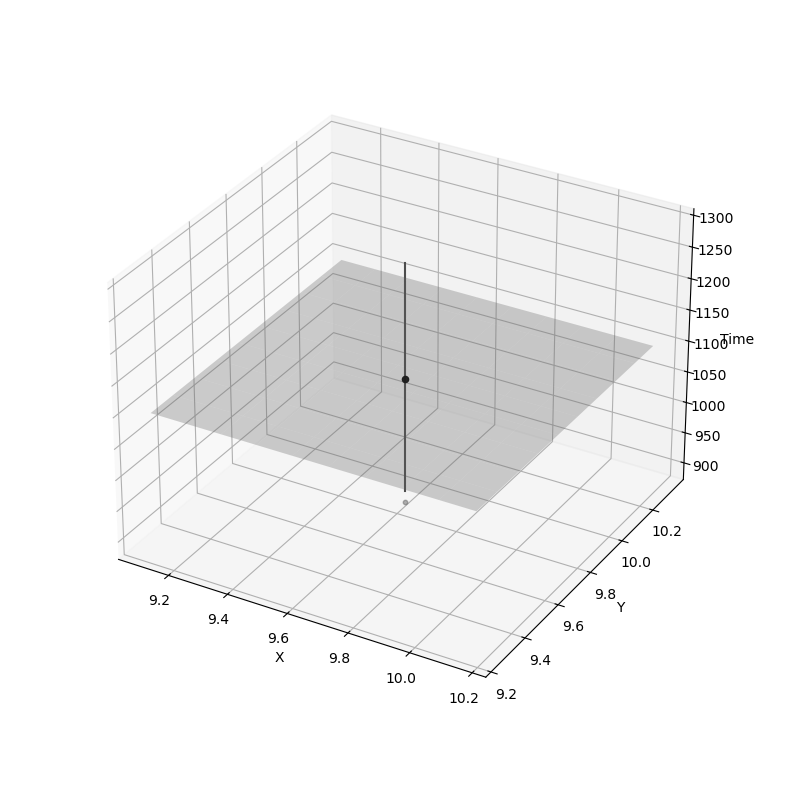

In [3]:
# Custom styling parameters
style_params = {
    'start_mean_color': None,  # Do not plot start mean points
    'end_mean_color': None, # Do not plot end mean points
    'mean_point_size': 10,
    'cylinder_color': (0.3, 0.3, 0.3),  # Dark grey
    'ppf_limits': (0.05, 0.95),  # Use different ppf limits
    'shadow_color': (0.4, 0.4, 0.4),  # grey
    'shadow_size': 10,
    'time_slice_color': (0.5, 0.5, 0.5),  # Grey
    'time_slice_alpha': 0.3,
    'time_slice_point_color': (0, 0, 0),  # Black
}

# Plot the points using the chrono_plot function with custom styling and a time slice plane
ax, _ = chrono_plot(points, style_params=style_params, time_slice=1100)
ax.set_box_aspect(None, zoom=0.85)

## Interpreting the Plot

In this example, we generated a single point with spatial coordinates and temporal distributions for its start and end dates. The plot visualizes the point's spatial location, its temporal presence, and its likelihood of being present at a specified time slice. This visual representation helps to introduce the concept of analyzing archaeological point patterns with both temporality and chronological uncertainty.

- Spatial Location: The x and y coordinates represent the geographical location of the archaeological site.
- Temporal Presence: The vertical gray pipe represents the temporal presence of the site within the space-time volume. This is determined by the probability distributions for the start and end dates.
- Time Slice: The grey, semi-transparent plane represents a specific time slice (in this case, at 1100 years). If a point's world line intersects the plane, the intersection is represented by a black dot (time slice point) on the plane, indicating that the point is 'present' in the pattern at that time.

## Understanding the Pipe and PPF

The pipe illustrates the site's temporal persistence within the space-time volume. The ends of the pipe are determined by the start and end distributions' percent point functions (PPF). The PPF, also known as the inverse cumulative distribution function (CDF), defines the specific points in time at which the cumulative probability reaches a certain value. For instance, a PPF value at the 1st percentile (PPF(0.01)) and the 99th percentile (PPF(0.99)) gives us a range within which we are 98% confident the event occurred.

To make this clearer, let's visualize the start and end distributions of a single point and the resulting world line in a 2D plot focused only on time and not space. The horizontal axis will represent the time duration during which the point exists in the space-time volume.

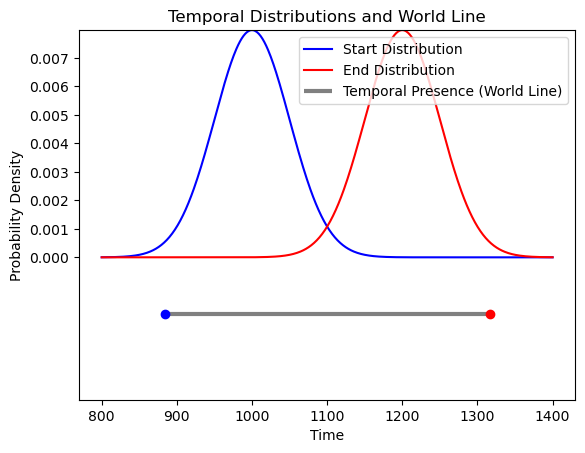

In [4]:
# Define the start and end distributions
start_age_mean = 1000
start_age_err = 50
end_age_mean = 1200
end_age_err = 50

start_dist = norm(loc=start_age_mean, scale=start_age_err)
end_dist = norm(loc=end_age_mean, scale=end_age_err)

# Generate a range of x values (time)
x = np.linspace(800, 1400, 500)

# Plot the probability density functions (PDFs)
plt.plot(x, start_dist.pdf(x), label='Start Distribution', color='blue')
plt.plot(x, end_dist.pdf(x), label='End Distribution', color='red')

# Determine the PPF limits (1st and 99th percentiles)
start_ppf = (start_dist.ppf(0.01), start_dist.ppf(0.99))
end_ppf = (end_dist.ppf(0.01), end_dist.ppf(0.99))

# Plot horizontal line (world line) between start and end PPFs
world_line_y = -0.002
plt.hlines(world_line_y, start_ppf[0], end_ppf[1], color='gray', linewidth=3, label='Temporal Presence (World Line)')

# Annotate the PPF limits
plt.scatter([start_ppf[0]], [world_line_y], color='blue', zorder=5)
plt.scatter([end_ppf[1]], [world_line_y], color='red', zorder=5)

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Probability Density')
plt.legend(loc='upper right')
plt.title('Temporal Distributions and World Line')
plt.ylim(-0.005, max(start_dist.pdf(x).max(), end_dist.pdf(x).max()))

# Set y-axis limits and ticks to avoid negative values
max_density = max(start_dist.pdf(x).max(), end_dist.pdf(x).max())
plt.ylim(-0.005, max_density)
plt.yticks( np.arange(0.000, max_density, 0.001) )

plt.show()

### Explanation of the Plot

In the plot:

- The blue curve represents the start distribution, showing the probability of the site's presence starting at different times.
- The red curve represents the end distribution, showing the probability of the site's presence ending at different times.
- The gray horizontal line near the x-axis represents the world line, indicating the temporal persistence of the site within the space-time volume.
- The blue dot marks the 1st percentiles of the start distribution.
- The red dot marks the 99th percentiles of the end distribution.

This plot helps visualize how the temporal distributions of a point define its temporal presence and how we can model the uncertainties associated with dating the point. The pipe in the 3D plot from before extends vertically between the PPF limits of the start and end distributions, representing the point's presence over time.

The chrono_plot function makes use of these concepts to visualize the temporal persistence of points in the space-time volume. The function takes the spatial coordinates (x, y) and the temporal distributions (start and end) of points and generates a 3D plot with:

- Pipes representing the temporal presence of each point.
- Time slice planes to visualize the presence of points at specific moments in time.

# Representing Spacetime Points in ChronoCluster

With these visualizations and spacetime concepts in mind, we can look at how ChronoCluster represents points in spacetime internally. The package uses a **Point** class. This class encapsulates both the spatial coordinates and the temporal distributions that describe when the point exists. Below, we will explain the Point class, its attributes, and key methods such as calculating inclusion probabilities for time slices.

## The Point Class

The Point class is designed to hold information about a single point in spacetime, including its spatial location and the temporal distributions that define its presence over time.

Attributes:

- x (float): The x-coordinate of the point.
- y (float): The y-coordinate of the point.
- start_distribution (scipy.stats.rv_continuous): The probability distribution for the start date.
- end_distribution (scipy.stats.rv_continuous): The probability distribution for the end date.

Key Methods:

1. Initialization (```__init__``` method):

The constructor initializes a new Point instance with given coordinates and distributions.

```python
def __init__(self, x, y, start_distribution, end_distribution, verbose=False):
    self.x = x
    self.y = y
    self.start_distribution = start_distribution
    self.end_distribution = end_distribution
    if verbose:
        print("Temporal consistency check...")
    self._check_distributions(verbose)
```

2. Checking Distributions (```_check_distributions``` method):

This private method checks the temporal consistency of the start and end distributions.

```python
def _check_distributions(self, verbose):
    overlap_ratio = self._calculate_overlap_ratio()
    if overlap_ratio > 0.25:
        print(f"Warning: Significant overlap between start and end distributions. Overlap ratio: {overlap_ratio:.2f}")
    start_mean = self.start_distribution.mean()
    end_mean = self.end_distribution.mean()
    if end_mean < start_mean:
        print(f"Warning: End date distribution mean ({end_mean}) is earlier than start date distribution mean ({start_mean}). Possible data error.")

```
3. Calculating Overlap Ratio (```_calculate_overlap_ratio``` method):

This private method calculates the overlap ratio between the start and end distributions.

```python
def _calculate_overlap_ratio(self):
    range_min = min(self.start_distribution.ppf(0.01), self.end_distribution.ppf(0.01))
    range_max = max(self.start_distribution.ppf(0.99), self.end_distribution.ppf(0.99))
    x = np.linspace(range_min, range_max, 1000)
    start_pdf = self.start_distribution.pdf(x)
    end_pdf = self.end_distribution.pdf(x)
    overlap_pdf = np.minimum(start_pdf, end_pdf)
    overlap_area = np.trapz(overlap_pdf, x)
    total_area_start = np.trapz(start_pdf, x)
    total_area_end = np.trapz(end_pdf, x)
    combined_area = total_area_start + total_area_end
    if combined_area == 0:
        print(f"Warning: Sum of density integrals is zero! Check that start and end dates are present and, if constant, not identical.")
        overlap_ratio = np.nan
    else:
        overlap_ratio = overlap_area / combined_area
    return overlap_ratio
```

4. Calculating Inclusion Probability (```calculate_inclusion_probability``` method):

This method calculates the inclusion probability of the point for a given time slice.

```python
def calculate_inclusion_probability(self, time_slice):
    start_prob = self.start_distribution.cdf(time_slice)
    if start_prob <= 0:  # If start probability is zero or negative
        return 0.0
    end_prob = self.end_distribution.sf(time_slice)
    return start_prob * end_prob
```

## Calculating Inclusion Probabilities

The last of these highlighted methods is a key concept in ChronoCluster. Inclusion probability -- the likelihood that a point is present in the pattern at a specific time slice -- is used throughout the package for analyses and plotting. The inclusion probability for a given point is calculated using the cumulative distribution function (CDF) of the start distribution and the survival function (SF) of the end distribution for that point.

- Cumulative Distribution Function (CDF): The CDF of a distribution gives the probability that a random variable is less than or equal to a certain value. For a given time slice $t$, the CDF of the start distribution $F_{start}(t)$ represents the probability that the point's existence has started by that time.

- Survival Function (SF): The survival function, also known as the complementary cumulative distribution function, gives the probability that a random variable is greater than a certain value. For a given time slice $t$, the SF of the end distribution $S_{end}(t)$ represents the probability that the point's existence has not ended by that time.

The inclusion probability, $P_{\text{inclusion}}$, at a time slice, $t$, is given by:

$$
P_{\text{inclusion}}(t) = F_{\text{start}}(t) \times S_{\text{end}}(t)
$$

Where:

- $F_{\text{start}}(t)$ is the CDF of the start distribution at time $t$
- $S_{\text{end}}(t)$ is the SF of the end distribution at time $t$


## Custom Probability Classes in ChronoCluster

ChronoCluster allows for flexibility in representing the temporal distributions of points. A point can have different start and end distributions, which can belong to different families of probability distributions. This flexibility is essential for modeling various types of temporal uncertainties and certainties in archaeological data.

### Dirac Delta: `ddelta`

One of the custom probability distribution classes used in ChronoCluster is the `ddelta` class. This class represents a Dirac delta distribution, which is useful for encoding historical information where we have no uncertainty about the start or end times of a point. The ddirac class inherits from scipy.stats.rv_continuous and approximates the Dirac delta function. This distribution is characterized by a single value dd---representing a fixed time---and it is used when we are certain about the start or end time of a point, as we might be with historical records of site founding or abandonment times, for example.

Here is the implementation of the ddirac class in ChronoCluster:

```python
class ddelta(rv_continuous):
    """Probability functions approximating the Dirac Delta"""
    
    def __init__(self, d):
        super().__init__(name='ddelta')
        self.d = d
        self.dist = self
        self.badvalue = np.nan
        self.a = d
        self.b = d
        self.xtol = 1e-14
        self.moment_type = 1
        self.shapes = None
        self.numargs = 0
        self.vecentropy = np.vectorize(self._entropy)
        self.generic_moment = np.vectorize(self._moment)

    def _pdf(self, x):
        """Probability density function"""
        return np.inf if x == self.d else 0

    def _cdf(self, x):
        """Cumulative distribution function"""
        return 1.0 if x >= self.d else 0.0
    
    def _sf(self, x):
        """Survival function"""
        return 1.0 - self._cdf(x)

    def _ppf(self, q):
        """Percent point function (inverse of cdf)"""
        return self.d

    def _rvs(self, size=None, random_state=None):
        """Random variates"""
        return np.full(size, self.d)

    def mean(self):
        """Mean of the distribution"""
        return self.d
    
    def var(self):
        """Variance of the distribution"""
        return 0.0

    def std(self):
        """Standard deviation of the distribution"""
        return 0.0

    def _entropy(self, *args, **kwargs):
        """Entropy of the distribution"""
        return 0.0

    def _moment(self, n, *args, **kwargs):
        """nth moment of the distribution"""
        if n == 1:
            return self.mean()
        elif n == 2:
            return self.var()**2
        else:
            return np.nan
```

#### Explanation of the ddelta Class

The `ddelta` class represents a distribution where all the probability mass is concentrated at a single point, `d`. This is useful for encoding certainty about the timing of an event.

- Probability Density Function (PDF): The _pdf method returns infinity at $d$ and zero elsewhere, approximating the Dirac delta function.
- Cumulative Distribution Function (CDF): The _cdf method returns 1 for any value greater than or equal to $d$ and $0$ otherwise.
- Survival Function (SF): The _sf method is the complement of the CDF, returning 1 minus the CDF.
- Percent Point Function (PPF): The _ppf method returns dd, indicating the exact point at which the probability mass is concentrated.
- Random Variates (RVS): The _rvs method generates random variates, which are always $d$.
- Mean and Variance: The mean method returns $d$, and the var method returns 0, indicating no variability.

For more information on the Dirac Delta function, you can refer to the following resources:

[Wikipedia: Dirac Delta Function](https://en.wikipedia.org/wiki/Dirac_delta_function)

[Wolfram MathWorld: Dirac Delta Function](https://reference.wolfram.com/language/ref/DiracDelta.html)

### Radiocarbon Date Distribution: `calrcarbon`

Radiocarbon dating is a method used to determine the age of an object containing organic material by measuring the amount of carbon-14 $^{14}C$ it contains. The decay of $^{14}C$ over time follows a known half-life, which allows us to estimate the age of the sample. However, radiocarbon dates need to be calibrated because the concentration of $^{14}C$ in the atmosphere has varied over time. Calibration curves, such as [IntCal20](https://intcal.org), are used to convert radiocarbon years into calendar years.

The calibration process typically involves fitting the measured $^{14}C$ age to a normal distribution with combined errors from both the measurement and the calibration curve. The probability density function (PDF) for a given calendar date $\tau$ is calculated as follows:

$$
f(\tau | \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(\mu - m(\tau))^2}{2\sigma^2} \right)
$$

where:

- $\mu$ is the measured radiocarbon age.
- $m(\tau)$ is the mean radiocarbon age from the calibration curve at calendar date $\tau$.
- $\sigma$ is the combined standard error, calculated as $\sqrt{\sigma_m^2 + \sigma_c^2}$, where $\sigma_m$ is the measurement error and $\sigma_c$ is the error from the calibration curve.

For more information:

[Wikipedia: Radiocarbon Dating](https://en.wikipedia.org/wiki/Radiocarbon_dating)

[Bronk Ramsey (2009)](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/F622173B70F9C1597F2738DEFC597114/S0033822200033865a.pdf/bayesian_analysis_of_radiocarbon_dates.pdf)

#### Accessing Calibration Curves

In ChronoCluster, we provide utility functions to access and process calibration curves. For example, the IntCal20 data can be downloaded and processed as follows:

```python
import pandas as pd

def download_intcal20():
    url = "https://intcal.org/curves/intcal20.14c"
    intcal20 = pd.read_csv(url, skiprows=10, delimiter=",")
    intcal20.columns = ["calbp", "c14bp", "c14_sigma", "f14c", "f14c_sigma"]
    
    # Create the dictionary in the required format
    intcal20_dict = {
        'calbp': intcal20['calbp'].values,
        'c14bp': intcal20['c14bp'].values,
        'c14_sigma': intcal20['c14_sigma'].values
    }
    return intcal20_dict

# Example usage to create initial intcal20 dictionary
intcal20 = download_intcal20()

# Users can add their custom curves to this dictionary
calibration_curves = {
    'intcal20': intcal20
}

# Users can update this dictionary with their custom curves
# Example: calibration_curves['custom_curve'] = custom_curve_data
```
#### Package Time Convention

For simplicity the package assumes that **years BP (ybp, or bp) are negative** and it would be wise for users who implement custom curves to do the same for use with ChronoCluster functions. But, this is not enforced or checked.

#### Spline Interpolation

To ensure the calibration curve is continuous and differentiable for all relevant methods, we use spline interpolation. This allows us to smoothly interpolate between the data points of the calibration curve. The interpolation is handled internally but can be affected or replaced by the user.

#### The `calrcarbon` Class

The calrcarbon class in ChronoCluster is designed to represent the calibrated radiocarbon date distribution. This class mirrors the functionality of rv_continuous in SciPy but does not inherit from it. It turned out to require too many custom method overrides to simply inherit `rv_continuous` and rely on SciPy's internal mechanisms for generating the distribution class. Instead, the `calrcarbon` class implements custom methods to handle the PDF, CDF, survival function, and random variate generation.

When an instance of the class is created, the __init__ method automatically creates interpolation objects for the calibration curve passed/selected by class parameters and an internal method is used to get data from the interpolators:

```python
class calrcarbon:
    """Custom calibrated radiocarbon date distribution"""
    
    _interp_mean = None
    _interp_error = None

    def __init__(self, calcurve, c14_mean=None, c14_err=None):
        self.a = -max(calcurve['calbp'])
        self.b = -min(calcurve['calbp'])
        if calrcarbon._interp_mean is None:
            calrcarbon._interp_mean = CubicSpline(-calcurve['calbp'], -calcurve['c14bp'], extrapolate=False)
            calrcarbon._interp_error = CubicSpline(-calcurve['calbp'], calcurve['c14_sigma'], extrapolate=False)
        self.c14_mean = c14_mean
        self.c14_err = c14_err
        self.name = 'calrcarbon'

    def _calc_curve_params(self, tau):
        curve_mean = calrcarbon._interp_mean(tau)
        curve_error = calrcarbon._interp_error(tau)
        return curve_mean, curve_error
...
```

*PDF: Probability Density Function*

The PDF of the `calrcarbon` distribution is defined as:

$$
\text{pdf}(\tau | \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(\mu - m(\tau))^2}{2\sigma^2} \right)
$$

where $\tau$ is the calendar date, $\mu$ is the measured radiocarbon age, and $\sigma$ is the combined error. The `_pdf` method in the `calrcarbon` class computes this value:

```python
def _pdf(self, tau, c14_mean, c14_err):
    curve_mean, curve_error = self._calc_curve_params(tau)
    combined_error = np.sqrt(c14_err**2 + curve_error**2)
    return norm.pdf(c14_mean, loc=curve_mean, scale=combined_error)
```

*CDF: Cumulative Distribution Function*

The CDF is computed by numerically integrating the PDF. The _cdf method uses the cumulative sum of the PDF values to approximate the CDF.

```python
def _cdf(self, tau, c14_mean, c14_err):
    t_values, pdf_values = self._get_pdf_values(c14_mean, c14_err)
    cdf_values = np.cumsum(pdf_values) * (t_values[1] - t_values[0])
    cdf_values /= cdf_values[-1]
    return np.interp(tau, t_values, cdf_values)
```

*SF: Survival Function*

The survival function (SF) is complementary to the CDF and is calculated as $1 − CDF(τ)$.

```python
def _sf(self, tau, c14_mean, c14_err):
    return 1.0 - self._cdf(tau, c14_mean, c14_err)
```

*RVS: Random Variates*

Random variates are generated using the [inverse transform sampling method](https://en.wikipedia.org/wiki/Inverse_transform_sampling). The _rvs method computes the inverse of the CDF to generate samples.

```python
def _rvs(self, c14_mean, c14_err, size=None, random_state=None):
    if size is None:
        size = 1
    t_values, pdf_values = self._get_pdf_values(c14_mean, c14_err)
    cdf_values = np.cumsum(pdf_values) * (t_values[1] - t_values[0])
    cdf_values /= cdf_values[-1]
    uniform_samples = np.random.uniform(0, 1, size=size)
    inverse_cdf = np.interp(uniform_samples, cdf_values, t_values)
    return inverse_cdf
```

*MEAN: Mean of a Calibrated Radiocarbon Date*

Calibrated radiocarbon date densities tend to be skewed and multimodal. As a result, to give a sense of the location of the calibrated distribution, the `calrcarbon` class calculates an expectation from the PDF with the `mean` method.

```python
def mean(self, c14_mean=None, c14_err=None):
        """Public method for the mean of the distribution"""
        if c14_mean is None:
            c14_mean = self.c14_mean
        if c14_err is None:
            c14_err = self.c14_err
        t_values, pdf_values = self._get_pdf_values(c14_mean, c14_err)
        return np.sum(t_values * pdf_values) * (t_values[1] - t_values[0])
```

#### Example and Plots

Let's take an example date to illustrate the calibration process and the methods implemented in the calrcarbon class. We will plot a calibrated radiocarbon date density (the PDF) using a ChronoCluster custom plotting method called `calrc_plot`, which will produce a density familiar to most who work with radicoarbon dates. And, then, we will use the `cdf` method to calculate the CDF from the PDF. For comparison, we will also sample the distribution (samples represented as a histogram in the first plot) and call the ECDF (empirical cumulative distribution function) on that sample (this sampling is handled by a custom plotting function). Plotting both the calculated CDF and the ECDF we can determine whether the `cdf` method is working as expected.

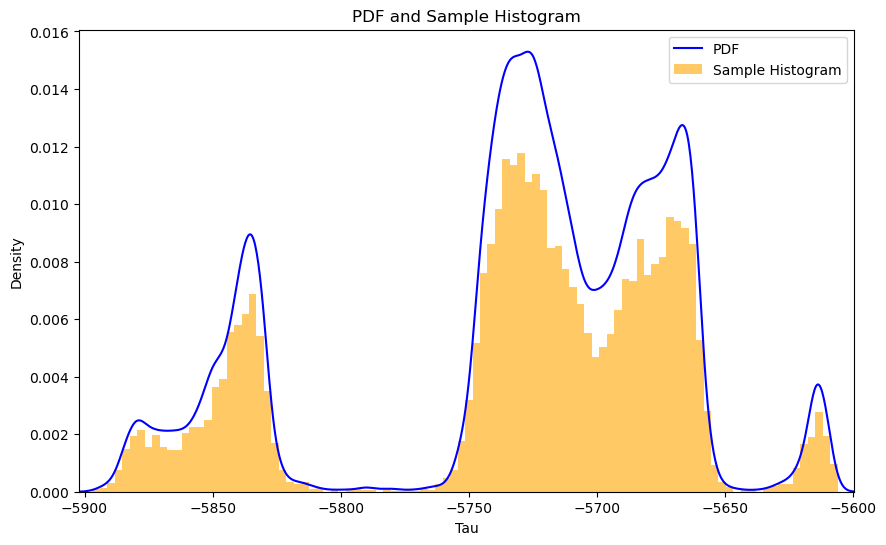

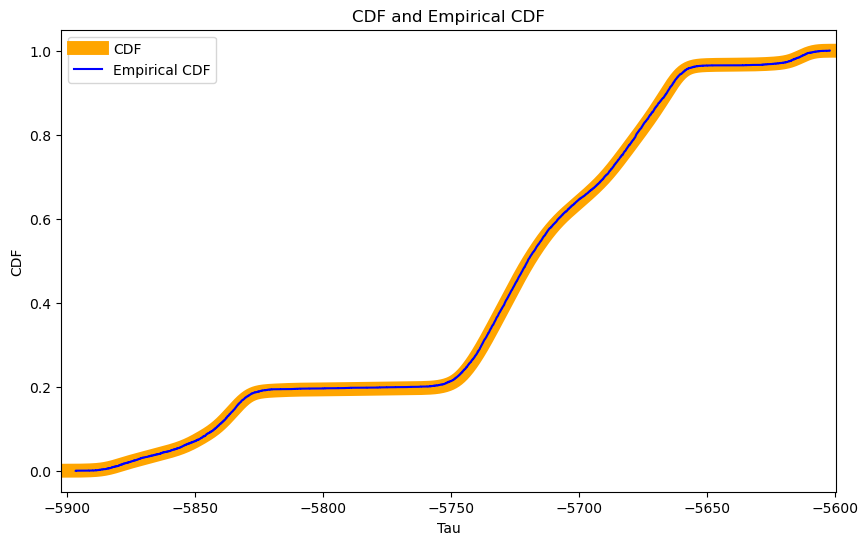

In [5]:
from statsmodels.distributions.empirical_distribution import ECDF
from chronocluster.calcurves import calibration_curves
from chronocluster.distributions import calrcarbon
from chronocluster.utils import calrc_plot

calcurve = calibration_curves['intcal20']

# Create the custom distribution
myc14dist = calrcarbon(calcurve, c14_mean=-5000, c14_err=20)

# Plot PDF and histogram
calrc_plot(myc14dist, plot_type='pdf', bins=100)

# Plot CDF and ECDF
calrc_plot(myc14dist, plot_type='cdf', bins=100)

# Using the Point Class with different start/end distributions

The ChronoCluster Point class (and relevant analyses) are intended to be flexible enough to account for points that have different start and end date/time distributions, as noted earlier. You can specify different distributions when you create a `Point` object by passing distribution objects that inherit from `scipy.stats.rv_continuous` (constinuous distribution objects). At the moment, though, Chronocluster's data i/o functions (`chronocluster.data` module) only supports Gaussian (`norm`), Uniform (`unif`) constant (`ddelta`) distributions. But, other functions and the `Point` class can take any valid distribution that has `.pdf`, `.cdf`, `._sf`, `.ppf`, and `.rvs` methods that return mathematically correct values. 

In the following example, we will create a `Point` object with:
- A normal distribution for the start time, representing some uncertainty.
- A `ddelta` distribution for the end time, indicating that the end time is known exactly.

In [6]:
point = clustering.Point(x = 10, 
                         y = 10, 
                         start_distribution = norm(loc=1000, scale=50),
                         end_distribution = ddelta(d=1200))

# Display the point's attributes
print(f"Point Coordinates: ({point.x}, {point.y})")
print(f"Start Distribution: Mean = {point.start_distribution.mean()}, Std = {point.start_distribution.std()}")
print(f"End Distribution: Mean = {point.end_distribution.mean()}, Std = {point.end_distribution.std()}")

# And show the tidy in-line printing method for the Point class
print(point)

Point Coordinates: (10, 10)
Start Distribution: Mean = 1000.0, Std = 50.0
End Distribution: Mean = 1200, Std = 0.0
Point(x=10, y=10, start_distribution=norm(loc=1000.0, scale=50.0), end_distribution=ddelta(d=1200))


And in this second example, we will create a `Point` object with:
- A `norm`al distribution for the start time, representing some uncertainty.
- A `calrcarbon` distribution for the end time, indicating that the end time is based on a radiocarbon date.
    - *note that the `calrcarbon` class has no `.std()` method because they tend to be highly multimodal and a standard deviation would be misleading.* 

In [7]:
point = clustering.Point(x = 10, 
                         y = 10, 
                         start_distribution = norm(loc=-5000, scale=50),
                         end_distribution = calrcarbon(calcurve, c14_mean=-4000, c14_err=20))

# Display the point's attributes
print(f"Point Coordinates: ({point.x}, {point.y})")
print(f"Start Distribution: Mean = {point.start_distribution.mean()}, Std = {point.start_distribution.std()}")
print(f"End Distribution: Mean = {point.end_distribution.mean()}, Var = {point.end_distribution.variance()}")

# And show the tidy in-line printing method for the Point class
print(point)

Point Coordinates: (10, 10)
Start Distribution: Mean = -5000.0, Std = 50.0
End Distribution: Mean = -4471.165342918402, Var = 1043.4738324132463
Point(x=10, y=10, start_distribution=norm(loc=-5000.0, scale=50.0), end_distribution=calrcarbon(c14_mean=-4000, c14_err=20))


# Multiple Points in ChronoCluster

To illustrate the capabilities of ChronoCluster in handling multiple points with varying temporal distributions, we can generate a set of random points. Each point will have its own start and end distributions, representing different durations of presence in the STV.

We will use the generate_random_points function to create these points. This function allows us to define cluster distributions, start and end date models, and uncertainties, and then generate a specified number of points based on these parameters.
The generate_random_points Function

The generate_random_points function generates random points based on specified spatial and temporal distributions. Here's a brief overview of its parameters:

- num_points (int): The number of points to generate.
- cluster_centers (list of tuples): The centers of the clusters around which points are generated.
- cluster_stds (list of floats): The standard deviations of the clusters.
- start_type (str): The type of distribution for the start dates (e.g., 'norm' for normal distribution).
- start_hyperparams (list): The hyperparameters for the start date distribution.
- end_type (str): The type of distribution for the end dates (e.g., 'constant' for a fixed end date).
- end_hyperparams (list): The hyperparameters for the end date distribution.

Using this function, we can generate points that are clustered in space and have varying degrees of temporal uncertainty.

## Example: Generating and Plotting Random Points

In the following example, we generate 40 random points divided into two clusters. The points have different start and end date distributions, demonstrating the flexibility of ChronoCluster.

Code Pipeline:

1. Define Cluster Distributions: We specify the centers and standard deviations for two clusters.
2. Create Start and End Age Distributions: We define different models and uncertainties for the start and end dates.
3. Generate Random Points: We use the generate_random_points function to create 40 points, with 20 points in each temporal distribution scenario.
4. Custom Styling: We define custom styling parameters for the plot.
5. Plot the Points: We use the chrono_plot function to visualize the points in the space-time volume.

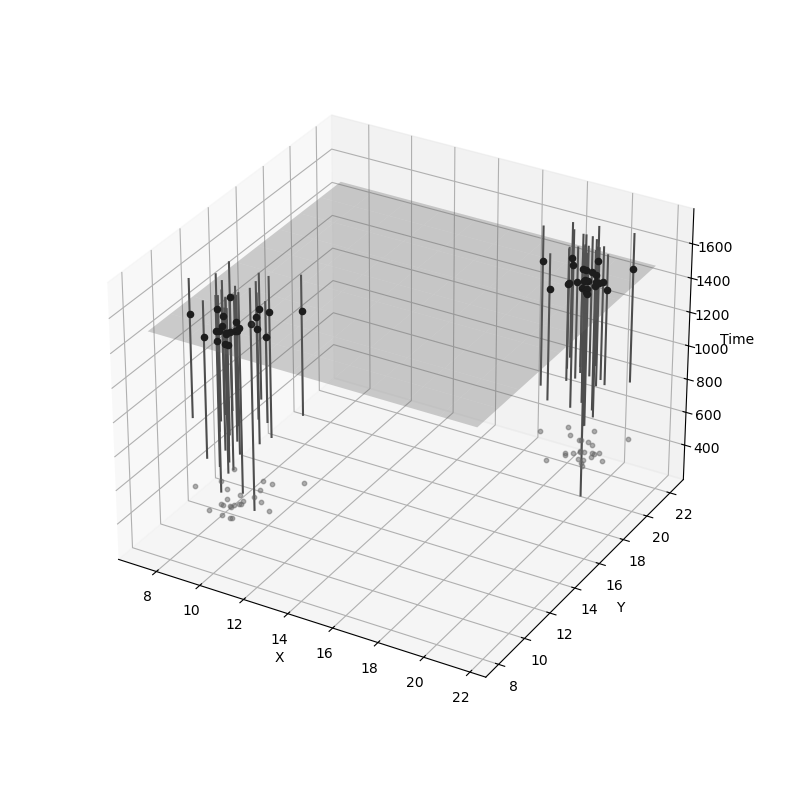

In [8]:
# define cluster distributions
cluster_centers = [(10, 10), (20, 20)]
cluster_stds = [1.0, 1.0]

# create random start and end ages with uncertainty for each point
# define dating models and uncertainties
start_type = 'norm'
start_hyperparams = [1000, 50, 100]
end_type = 'constant'
end_hyperparams = [1700]

# finally, generate 100 random points using the above models
points = generate_random_points(50, 
                                cluster_centers, 
                                cluster_stds, 
                                start_type, 
                                start_hyperparams, 
                                end_type, 
                                end_hyperparams)

# Custom styling parameters
style_params = {
    'start_mean_color': None,  # Do not plot start mean points
    'end_mean_color': None, # Do not plot end mean points
    'mean_point_size': 10,
    'cylinder_color': (0.3, 0.3, 0.3),  # Dark grey
    'ppf_limits': (0.05, 0.95),  # Use different ppf limits
    'shadow_color': (0.4, 0.4, 0.4),  # grey
    'shadow_size': 10,
    'time_slice_color': (0.5, 0.5, 0.5),  # Grey
    'time_slice_alpha': 0.3,
    'time_slice_point_color': (0, 0, 0),  # Black
}

# Plot the points using the chrono_plot function with custom styling and a time slice plane
ax, _ = chrono_plot(points, style_params=style_params, time_slice=1500)
ax.set_box_aspect(None, zoom=0.85)

## Explanation of the Plot

The plot generated by the above code illustrates several key points:

1. Different Points Have Different Presence/Duration in the STV: Each point's **temporal presence** is represented by a vertical cylinder (pipe), the **world line** that extends between its start and end dates. Some points have longer durations (pipes) than others.

2. **World Lines** and **Time Slice** Intersections: Some points have world lines (pipes) that do not intersect the given time slice at 1500 years. These points are not present in the pattern at that specific time, which is visualized by the absence of black dots on the time slice plane at their locations.

3. **Palimpsest** Representation: When we ignore the time dimension, we are looking at the palimpsest— the overlapping of all points in the spatial domain. This is represented in the plot by the shadows of the points on the 'floor' of the plot, showing the aggregated spatial distribution without considering the temporal dimension.

# Pairwise Distances and Clustering Statistics in ChronoCluster

In spatial analysis, pairwise distances are a fundamental measure used to explore clustering structures. By calculating the distances between each pair of points, we can understand how closely points are grouped together. However, temporality and chronological uncertainty complicate these calculations because points may not be contemporaneous and their exact positions in time are uncertain.

## Temporality and Chronological Uncertainty

Temporality refers to the fact that each point exists in space and time, not just space. Chronological uncertainty refers to the inaccuracies in dating these points. Traditional clustering statistics do not account for these complexities, leading to potentially misleading results.
Approach in ChronoCluster

ChronoCluster addresses these issues by:

- Propagating Uncertainty and Temporality: Using Monte Carlo (MC) simulations to propagate chronological uncertainty.
- Applying Spacetime Thinking: Analyzing points in both spatial and temporal dimensions.
- Using Time Slices: Breaking the analysis into discrete time slices to handle temporality.

Key Functions:

- in_probs Function: Precomputes inclusion probabilities based on age models and time slices.
- mc_samples Function: Runs Monte Carlo simulations to generate probable lists of points included in each time slice.
- temporal_pairwise Function: Produces pairwise distances to explore clustering structures over time.
- clustering_heatmap Function: Visualizes temporality and propagates chronological uncertainty into a clustering plot.

## Example: Pairwise Distances with Temporal and Chronological Uncertainty

The following example demonstrates how to compute and visualize pairwise distances with temporal and chronological uncertainty.

### Step 1: Define Time Slices

In [9]:
# Define the time slices
start_time = 1000
end_time = 1700
time_interval = 50
time_slices = np.arange(start_time, end_time, time_interval)

### Step 2: Run Monte Carlo Simulations

In [10]:
# Run the Monte Carlo simulation to get an ensemble of probable 
# lists of points included in each time slice.
num_iterations = 100
simulations = clustering.mc_samples(points, 
                                    time_slices, 
                                    num_iterations=num_iterations)

### Step 3: Determine Maximum Distance

In [11]:
# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

### Step 4: Produce Pairwise Distances

In [12]:
# Produce pairwise distances to explore clustering structure
pairwise_density, support = clustering.temporal_pairwise(simulations, 
                                                         time_slices, 
                                                         bw=0.5, 
                                                         use_kde=True, 
                                                         max_distance=max_distance)

### Step 5: Visualize Clustering
We can visualize the clustering in a couple of ways. First with a heat map and then by randomly sleecting a time slice for plotting.

(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Heatmap of Mean Pairwise Distances(d) Function Over Time and Distance'}, xlabel='Time Slices', ylabel='Distances'>)

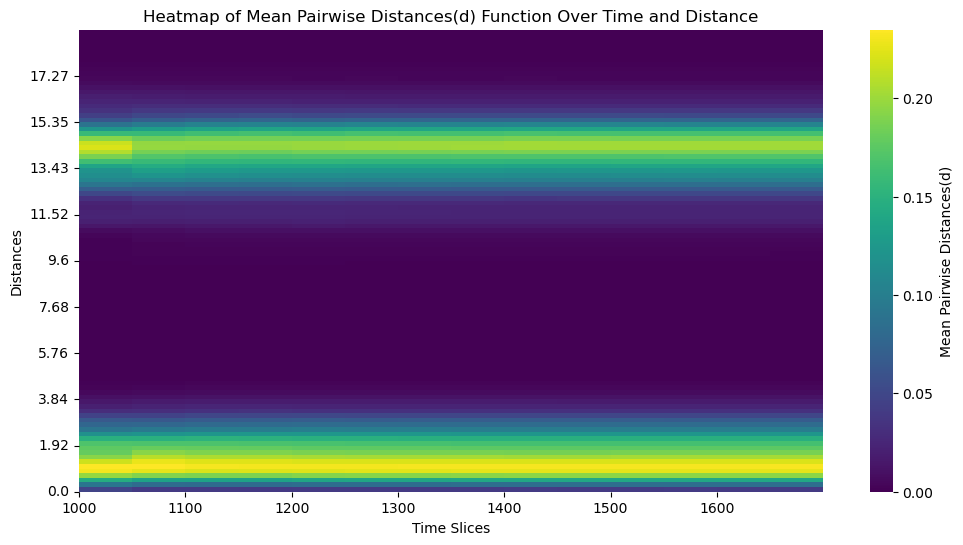

In [13]:
# Visualize clustering with heatmap
clustering_heatmap(pairwise_density,
                   support,
                   time_slices,
                   result_type='Pairwise Distances')

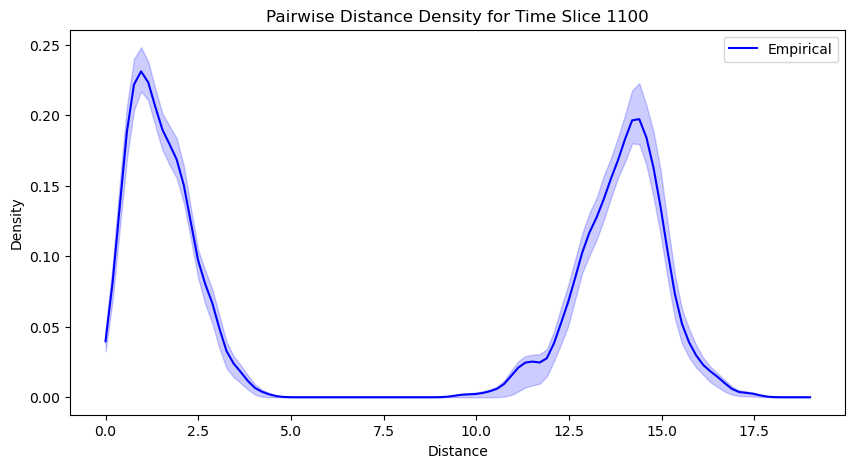

In [14]:
from chronocluster.utils import plot_pdd

time_slice_idx = np.where(time_slices == 1100)[0][0]  # corresponding to time 1100

# List of density arrays
density_arrays = [pairwise_density]

# Generate the plot and get the figure and axis objects
fig, ax = plot_pdd(
    time_slices=time_slices,
    time_slice_idx=time_slice_idx,
    support=support,
    density_arrays=density_arrays,
    quantiles=[0.025, 0.975],
    density_names=["Empirical"],
    colors=["blue"]
)

# Show the plot
plt.show()

### Interpreting the Clustering Heatmap

The heatmap generated by the `clustering_heatmap` function provides a visual representation of the temporal clustering structure of the points. Here’s an expanded explanation based on the observed heatmap:

**Axes and Color Scale**

- X-Axis (Time Slices): The x-axis represents discrete time slices from 1000 to 2000 years, showing the temporal dimension of the analysis.
- Y-Axis (Distances): The y-axis represents distances between points in the spatial plane (x, y coordinates).
- Color Scale: The color scale represents the mean pairwise distances. The color gradient from purple (low density) to yellow (high density) indicates the relative density of pairwise distances for each time slice.

**Observations**

1. Persistent Clustering Over Time:
    - The heatmap shows persistent clustering through time, indicated by the consistent bands of color. This means that there is a stable structure of clusters in the data across the analyzed time period.

2. Peaks in Pairwise Distances:
    - There are notable peaks in pairwise distances at around 2 and 14 spatial units. These peaks correspond to the smaller clusters and the distance between clusters, respectively.
    - The distance of 2 units represents the average distance between points within the same cluster.
    - The distance of 14 units represents the distance between points in different clusters.

3. Chronological Uncertainty Propagation:
    - The use of Monte Carlo simulations propagates the chronological uncertainty through the time slices. This is reflected in the smooth transitions and variations in color intensity over time.
    - The heatmap marginalizes the propagated chronological uncertainty, averaging the pairwise distances over multiple simulations. But it's important to note that the map represents only one density estimate---in this case the average across MC simulations---which is marginalizing out the uncertainty and is necessary for vizualization. In reality, there is a whole distribution of these surfaces that reflects the chronological uncertainty and samples of that distribution are contained in the `pairwise_density` array.

4. Clusters and Time Slices:
    - In general with this approach, the presence of distinct clusters could be observed across different time slices. Some clusters might not be present in all time slices due to the temporal uncertainty of the points and their temporality. In the simple example above, there is no meaningful temporality, just chronological uncertainty.
    - Points with worldlines that do not intersect a given time slice would not be present in the pattern at that specific time, which would be seen by the absence of corresponding high-density areas in the heatmap for those time slices in cases where the uncertainty was significant and/or there was also temporality in the point pattern.

## Statistical Significance and Complete Spatial Randomness
In spatial analysis, evaluating the statistical significance of observed point patterns against a null hypothesis of Complete Spatial Randomness (CSR) is crucial. CSR assumes that points are distributed uniformly and independently across the study area. By comparing the observed point patterns to this null model, we can determine whether the observed clustering or dispersion is statistically significant in the sense that the patterns would be highly unlikely to occurr if the points were randomly distributed.

ChronoCluster provides functions to perform this comparison and evaluate the statistical significance of point patterns with temporal and chronological uncertainty.

## Example: Evaluating Statistical Significance Against CSR

The following example demonstrates how to calculate the p-values for density differences between observed points and a simulated CSR baseline, and then visualize these p-values using a heatmap. The basic analytical pipeline will involve generating a random point scatter that has the same temporal characteristics of the real (in our case, of course, simulated) data. To do this, ChronoCluster has a function called `csr_sample` that takes a list of `Point` instances and generates a new list with coordinate values randomized in a way that reflects the CSR assumption. Of course, a 'study area' has to be defined and passed in as coordinate limits as well.

### Step 1: Create CSR Data
We need to create a list of MC simulations as before, but this time with the CSR data. So, we follow the same procedure as above, but this time pass additional parameters to `mc_samples` including the `csr_sample` function. Now `mc_samples` will be a list of sublists with each sublist containing a probably set of the points that existed at the corresponding time from `time_slices`. Importantly, these probable points will have had their coordinates resampled by the `csr_sample` function (which could be user defined as long as it takes a list of Point objects as its first parameter and returns the list of sublists as its first return object).

In [15]:
# Generate one sample of CSR from the points list for plotting
csr_points, _ = clustering.csr_sample(points,
                                        x_min=x_min,
                                        x_max=x_max,
                                        y_min=y_min,
                                        y_max=y_max)

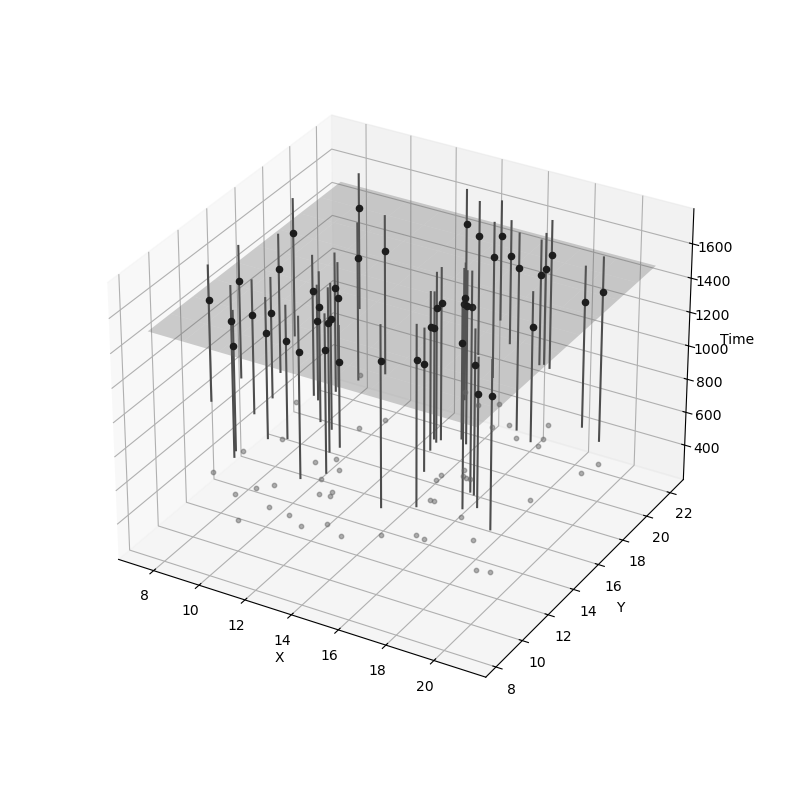

In [17]:
# Custom styling parameters
style_params = {
    'start_mean_color': None,  # Do not plot start mean points
    'end_mean_color': None, # Do not plot end mean points
    'mean_point_size': 10,
    'cylinder_color': (0.3, 0.3, 0.3),  # Dark grey
    'ppf_limits': (0.05, 0.95),  # Use different ppf limits
    'shadow_color': (0.4, 0.4, 0.4),  # grey
    'shadow_size': 10,
    'time_slice_color': (0.5, 0.5, 0.5),  # Grey
    'time_slice_alpha': 0.3,
    'time_slice_point_color': (0, 0, 0),  # Black
}

# Plot the points using the chrono_plot function with custom styling and a time slice plane
ax, _ = chrono_plot(csr_points, style_params=style_params, time_slice=1500)
ax.set_box_aspect(None, zoom=0.85)

### Step 2. Calculate Pairwise Distance Density for CSR data

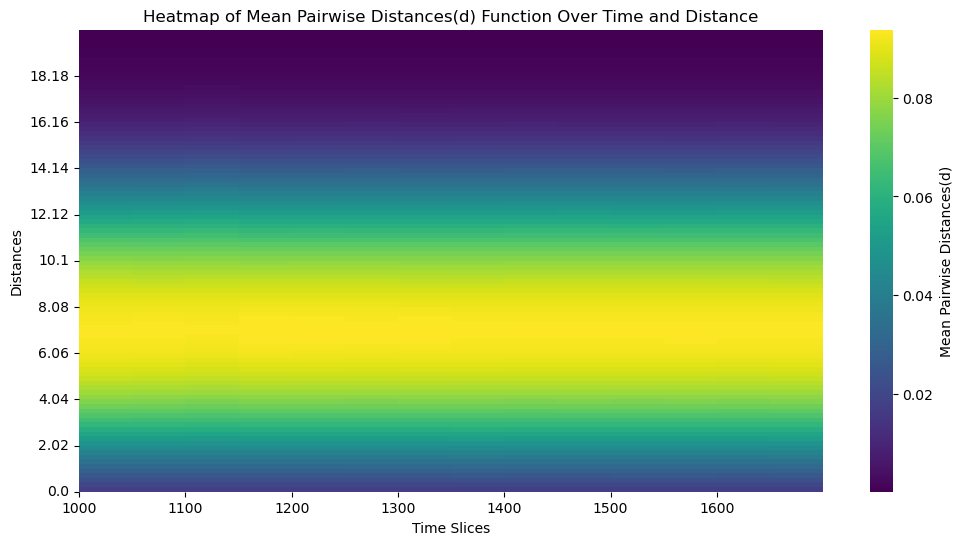

In [18]:
num_iterations = 100
csr_simulations = clustering.mc_samples(points=points, 
                                        time_slices=time_slices, 
                                        num_iterations = num_iterations,
                                        null_model=clustering.csr_sample,
                                        x_min=x_min, 
                                        x_max=x_max, 
                                        y_min=y_min, 
                                        y_max=y_max)

# Calulate the pairwise distances for the CSR sample
csr_pairwise_density, csr_support = clustering.temporal_pairwise(csr_simulations, 
                                                                 time_slices, 
                                                                 bw = 0.5, 
                                                                 use_kde = True, 
                                                                 max_distance = max_distance)

# Visualize clustering with heatmap
clustering_heatmap(csr_pairwise_density,
                   csr_support,
                   time_slices,
                   result_type='Pairwise Distances')

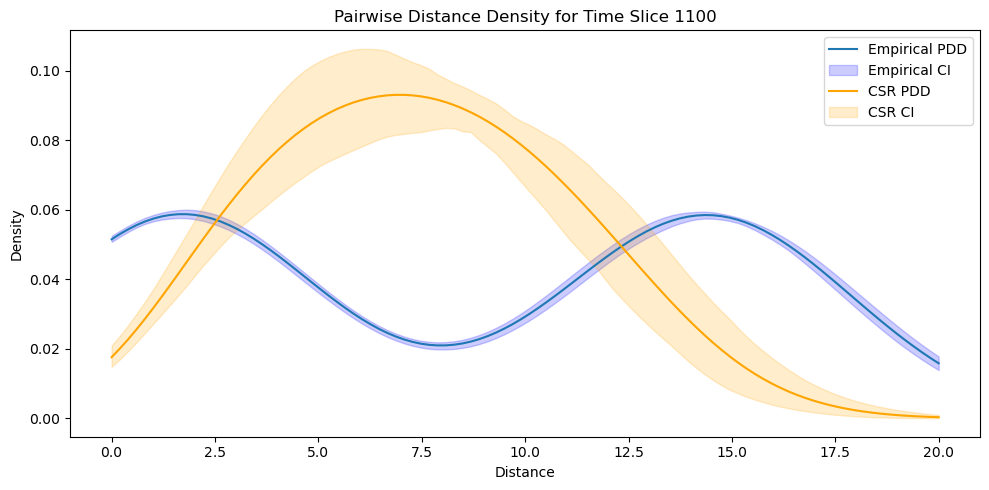

In [19]:
time_slice_idx = np.where(time_slices == 1100)[0][0]  # corresponding to time 1100
time_slice = time_slices[time_slice_idx]

# Define quantiles for the error envelope
quantiles = [0.025, 0.975]  # 95% confidence interval

# Calculate mean and quantiles for empirical PDD
empirical_mean = np.mean(pairwise_density[:, time_slice_idx, :], axis=1)
empirical_lower = np.quantile(pairwise_density[:, time_slice_idx, :], quantiles[0], axis=1)
empirical_upper = np.quantile(pairwise_density[:, time_slice_idx, :], quantiles[1], axis=1)

# Calculate mean and quantiles for CSR PDD
csr_mean = np.mean(csr_pairwise_density[:, time_slice_idx, :], axis=1)
csr_lower = np.quantile(csr_pairwise_density[:, time_slice_idx, :], quantiles[0], axis=1)
csr_upper = np.quantile(csr_pairwise_density[:, time_slice_idx, :], quantiles[1], axis=1)

# Create a line plot
fig, axs = plt.subplots(figsize=(10, 5))

# Plot mean and quantiles for empirical PDD
axs.plot(support, empirical_mean, label='Empirical PDD')
axs.fill_between(support, empirical_lower, empirical_upper, color='blue', alpha=0.2, label='Empirical CI')

# Plot mean and quantiles for CSR PDD
axs.plot(csr_support, csr_mean, label='CSR PDD', color='orange')
axs.fill_between(csr_support, csr_lower, csr_upper, color='orange', alpha=0.2, label='CSR CI')

# Add labels and title
axs.set_xlabel('Distance')
axs.set_ylabel('Density')
axs.set_title(f'Pairwise Distance Density for Time Slice {time_slice}')

# Add legend
axs.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

### Step 3: Calculate P-Values for Density Differences

We use the p_diff function to calculate the p-values for density differences between the observed points and the simulated CSR baseline for each distance and time slice. Importantly, the distribution we are using for inference is for another random variable, $p_{diff} = P(observed - csr)$ that reflects the chronological uncertainty in the original data. The `p_diff` function, therefore, takes in the observed statistic array (with shape `(distance, time, mc_iterations)`) and a comparable array for the CSR simulated data and it returns p-values for the differences where the distribution refers to the `mc_simulations` axis in the arrays. So, we are considering the distirbution with respect to chronological uncertainty because samples from the start/end distributions of the points are ultimately used to produce the iterations that are reflected in that axis of the arrays.

The specific calculations for the p-values are as follows, where `obs` is an observed array and `csr` is the CSR baseline:

1. **Mean Calculation**:
   Calculate the mean difference ($\mu_{\Delta_{ij}}$) between the observed and CSR pairwise densities across the iterations (axis=2):
   $$
   \mu_{\Delta_{ij}} = \frac{1}{N} \sum_{k=1}^{N} (\text{obs}_{ijk} - \text{csr}_{ijk})
   $$
   where $N$ is the number of iterations, $i$ indexes the distances, $j$ indexes the time slices, and $k$ indexes the iterations.

2. **Standard Deviation Calculation**:
   Calculate the standard deviation of the differences ($\sigma_{\Delta_{ij}}$) across the iterations (axis=2):
   $$
   \sigma_{\Delta_{ij}} = \sqrt{\frac{1}{N} \sum_{k=1}^{N} \left[(\text{obs}_{ijk} - \text{csr}_{ijk}) - \mu_{\Delta_{ij}}\right]^2}
   $$

3. **Z-score Calculation**:
   Calculate the z-scores for each pair of distance and time slice:
   $$
   z_{\Delta_{ij}} = \frac{\mu_{\Delta_{ij}}}{\sigma_{\Delta_{ij}}}
   $$

4. **P-value Calculation**:
   Calculate the p-value using the CDF of the standard normal distribution:
   $$
   p = \begin{cases}
   1 - \Phi(z_{\Delta_{ij}}) & \text{if ``greater''} \\
   \Phi(z_{\Delta_{ij}}) & \text{if ``less''}
   \end{cases}
   $$
   where $\Phi$ is the CDF of the standard normal distribution.

It's important to emphasize that the p-values calculated in this way are **not** referring directly to the probability that the difference between the observed and CSR values is greater than zero. They refer to the probability of observing a value as extreme or more extreme under the null hypothesis, which in this case is the standard normal distribution (a normal distribution centred on zero and scaled). As a result, these values are comparable to a standard one-tailed z-test. That said, given that,

1. the differences are calculated as $obsserved - csr$,
2. they are standardized, and
3. the CDF is used to find the p-value

low values imply differences that are positive if $p < 0.5$. This is because the null (standard normal) is centered on zero, which would have a CDF value of $0.5$. Extremely low p-values, say $p < 0.05$, would indicate that the probability of observing a more extremely positive difference is low (5% or less, in case of $p < 0.05$). So, while the p-values don't directly relate to the probability that the observed difference is greater than zero, this inequality is implied because of the way the differences are calculated and the nature of the test design as long as $p < 0.5$. Higher p-values suggest a _negative difference_, which has a specific interpretation for some clustering statisitcs, like Ripley's K.

In [20]:
# Calculate the p-values for density differences between the observed points and 
# the simulated CSR baseline per distance and temporal slice
p_diff_array, diff_array = clustering.p_diff(pairwise_density, csr_pairwise_density)

### Step 4: Plot the Heatmap of P-Values

The `pdiff_heatmap` function is used to visualize the p-values, highlighting the statistical significance of the observed clustering patterns. The interpretation depends on the underlying stastic, which at the moment can be either one of the Ripley functions (K, L, or G) or the pairwise distance density.

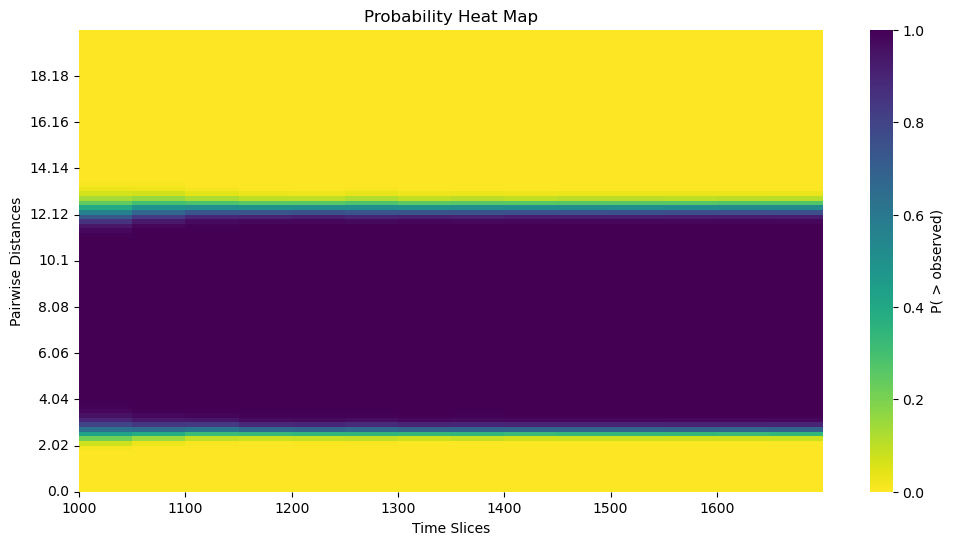

In [21]:
# Plot the heatmap of probabilities
pdiff_heatmap(p_diff_array,
              time_slices,
              csr_support)

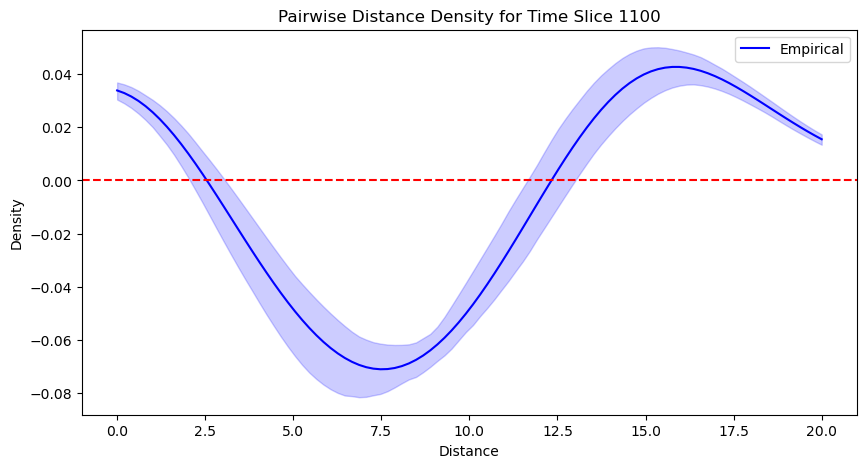

In [22]:
# List of density arrays
density_arrays = [diff_array]

# Generate the plot and get the figure and axis objects
fig, ax = plot_pdd(
    time_slices=time_slices,
    time_slice_idx=time_slice_idx,
    support=support,
    density_arrays=density_arrays,
    quantiles=[0.025, 0.975],
    density_names=["Empirical"],
    colors=["blue", "green"]
)

# Add a horizontal line at y=0
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

# Show the plot
plt.show()

### Explanation of the Code

1. Calculate P-Values (p_diff Function):
        - The p_diff function compares the observed clustering statistic to the CSR baseline for that statistic.
        - It calculates the p-values for the difference in density for each distance and time slice, indicating the probability that the observed pattern is different from CSR in a particular direction indicated by a parameter, `condition` that defaults to 'greater'.

2. Visualize P-Values (pdiff_heatmap Function):
        - The pdiff_heatmap function plots a heatmap of the p-values, with time slices on the x-axis and distances on the y-axis.
        - The color gradient represents the p-values, with warmer colors indicating lower (significant) p-values and cooler colors indicating higher (insignificant) p-values.
3. Alternative Visualization:
        - The pdiff values can also be viewed for any given time slice, as the plot that follows the heatmap shows.
        - The mean (blue line) indicates the difference between the empirical PDD and a null model.
        - The uncertainty envelope around the mean represents quantiles of that difference, which in turn reflect spatiotemporal uncertainty.

### Interpretation of the Heatmap

Since we are looking at the difference between the observed pairwise distance distribution and a comparable CSR baseline,

1. Low p-values:
        - Statistically significant clustering and/or point-distance structure at the indicated distance(s) and time(s) within the STV.
        - Significant here means the probability of differences as extreme or more extreme than the observed difference is low (with the probability given by the p-value).
        - In the heatmap, these significant regions are indicated by warmer colours.
2. High p-values:
        - Regions of the pairwise distance distribution (distance(s) and time(s)) that do not differ significantly from CSR within the STV.
        - In the heatmap, these non-significant regions are indicated by cooler colours.

## Other ChronoCluster Clustering Statistics
Using the same overall pipeline described above, the `ChronoCluster` package provides support for clustering analyses involving three other fundamental cluster statistics:

1. Ripley's K Function:
        - Purpose: Measures the number of points within a given distance of each point, adjusted for the overall density of points.
        - Function: temporal_cluster
        - Parameters: calc_K=True

2. Ripley's L Function:
        - Purpose: A linear transformation of Ripley's K function that stabilizes the variance under CSR.
        - Function: temporal_cluster
        - Parameters: calc_L=True

3. Pair Correlation Function (Ripley's G Function):
        - Purpose: Measures the density of points at a specific distance from a given point, providing insight into the spatial structure at different scales.
        - Function: temporal_cluster
        - Parameters: calc_G=True

### Example Code for Ripley's K, L, and G Functions

Below is the example code for calculating Ripley's K, L, and G functions over time using the ChronoCluster package. This code is for reference and demonstrates how to set up the calculations, but we won't compute anything in this slide:

```python
# Define distances for Ripley's K function
distances = np.linspace(np.finfo(float).eps, max_distance, num=40)

# Calculate K, L, and G functions over time
k_results, l_results, g_results = clustering.temporal_cluster(simulations, 
                                                              distances, 
                                                              time_slices, 
                                                              calc_K=True, 
                                                              calc_L=True,
                                                              calc_G=True)

# Visualize the K function results with a heatmap
clustering_heatmap(k_results, distances, time_slices)
```

### Explanation

1. Define Distances:
        - We define a range of distances over which to calculate the clustering statistics, ensuring that the distances cover the relevant scales of spatial interaction.

2. Calculate Clustering Statistics:
        - The temporal_cluster function is used to calculate Ripley's K, L, and G functions for each time slice and distance.
        - The parameters calc_K=True, calc_L=True, and calc_G=True indicate that all three statistics should be computed.

3. Visualize Results:
        - The results of the K function are visualized using a heatmap, similar to the approach taken for pairwise distances.
        - The clustering_heatmap function can be used to plot the results for L and G functions as well, providing insights into the clustering patterns over time and distance.

## Baseline Informed Spatial Expectation
Sometimes Complete Spatial Randomness (CSR) within an arbitrarily defined study area is an inadequate baseline (null). Imagine you're analyzing the spatial distribution of archaeological sites in a landscape shaped by natural features like rivers, mountains, or coastlines. These geographic elements exert a powerful influence over where people choose to settle, so a null model that assumes spatial randomness risks missing meaningful patterns by ignoring the influence of the landscape itself. At the same time, human activity will almost never distribute uniformly at random within an arbitrary study area owing to resource heterogeneity and the tendency at large scales for humans (and other animals) to congergate. This natural spatial bias means that patterns we observe could easily reflect baseline process constraints rather than any structured point patterns that reflect specific past cultural, eonomic, and social processes of interest. As a result, the structure imposed by landscape and otehr baseline contraints could distort or obscure socially, culturally, or economically derived clustering. Using CSR could also potentially lead to distracting signals (effectively additional noise) in the pair-wise distance distribution (and down-stream statistics). Thus, CSR is rarely a very good null hypothesis for human activity.

To address this, a Baseline Informed Spatial Expectation (BISE) null model incorporates these constraints directly. Instead of evaluating spatial patterns against CSR, BISE can be used to simulate a spatial distribution that conforms to broad landscape influences---such as barriers, attractors, or environmental suitability gradients---and overall shape/size of the data cloud while remaining agnostic about finer-grained structures (site clustering) that might still emerge within the overall distribution of points. This approach allows for a baseline that is more sensitive to the natural, lansdscape context of human settlement, helping to reveal spatial structures that are genuinely sociocultural, rather than simply a byproduct of the landscape. With BISE, researchers can better differentiate between patterns that reflect meaningful organization and those that stem from the physical environment itself.

### Simulation Example
Let's imagine a collection of archaeological site locations that follow a somewhat linear landscape constraint, like sites in river valley. We can simulate, as before, a point data set using the now familiar chronocluster tools. When plotted, as you see below, the sites trend along a line. Importantly, despite there being two separate clusters of points, the tails overlap. And, thanks to the linear trend we've introduced here, the 'clustering' is more evident in the direction transverse to the direction of the trend than it is around the seperate means. 

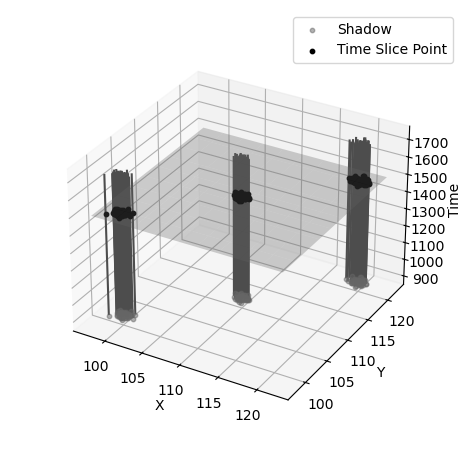

In [110]:
# Define cluster distributions, but with a linear trend across the landscape (e.g., river valley)
cluster_centers = [(100, 100), (110, 110), (120, 120)]
cluster_stds = [0.5, 0.5, 0.5]

# Define parameters for the temporal distributions
start_age_mean = 1000
start_age_err = 50
end_age_mean = 1700
end_age_err = 10

# Define a directional trend to simulate a river valley
num_points_per_cluster = 50

# Generate points with clusters along a directional trend
points = []
for center, std in zip(cluster_centers, cluster_stds):
    # Generate base points for this cluster
    x_coords = np.random.normal(center[0], std, num_points_per_cluster)
    y_coords = np.random.normal(center[1], std, num_points_per_cluster)

    for x, y in zip(x_coords, y_coords):
        # Create start and end distributions for each point
        start_dist = norm(loc=start_age_mean, scale=start_age_err)
        end_dist = norm(loc=end_age_mean, scale=end_age_err)
        
        # Append the point with spatial and temporal distributions
        point = Point(x=x, y=y, start_distribution=start_dist, end_distribution=end_dist)
        points.append(point)

# Custom styling parameters
style_params = {
    'start_mean_color': None,  # Do not plot start mean points
    'end_mean_color': None,  # Do not plot end mean points
    'mean_point_size': 10,
    'cylinder_color': (0.3, 0.3, 0.3),  # Dark grey
    'ppf_limits': (0.05, 0.95),  # Use different ppf limits
    'shadow_color': (0.4, 0.4, 0.4),  # grey
    'shadow_size': 10,
    'time_slice_color': (0.5, 0.5, 0.5),  # Grey
    'time_slice_alpha': 0.3,
    'time_slice_point_color': (0, 0, 0),  # Black
}

# Plot the points using the chrono_plot function with custom styling and a time slice plane
ax = chrono_plot(points, style_params=style_params, time_slice=1500)
ax.set_box_aspect(None, zoom=0.85)


In [111]:
points

[Point(x=100.41662472053874, y=100.46714693089343, start_distribution=norm(loc=1000.0, scale=50.0), end_distribution=norm(loc=1700.0, scale=10.0)),
 Point(x=100.01411598305444, y=100.41445573623884, start_distribution=norm(loc=1000.0, scale=50.0), end_distribution=norm(loc=1700.0, scale=10.0)),
 Point(x=100.85234851663581, y=100.19850501675455, start_distribution=norm(loc=1000.0, scale=50.0), end_distribution=norm(loc=1700.0, scale=10.0)),
 Point(x=100.11010341972545, y=100.03441930192677, start_distribution=norm(loc=1000.0, scale=50.0), end_distribution=norm(loc=1700.0, scale=10.0)),
 Point(x=100.02033640352985, y=100.28849806988538, start_distribution=norm(loc=1000.0, scale=50.0), end_distribution=norm(loc=1700.0, scale=10.0)),
 Point(x=100.4130397497323, y=100.074408809502, start_distribution=norm(loc=1000.0, scale=50.0), end_distribution=norm(loc=1700.0, scale=10.0)),
 Point(x=99.46284586047504, y=100.1219042359344, start_distribution=norm(loc=1000.0, scale=50.0), end_distribution=

(100, 14, 100)


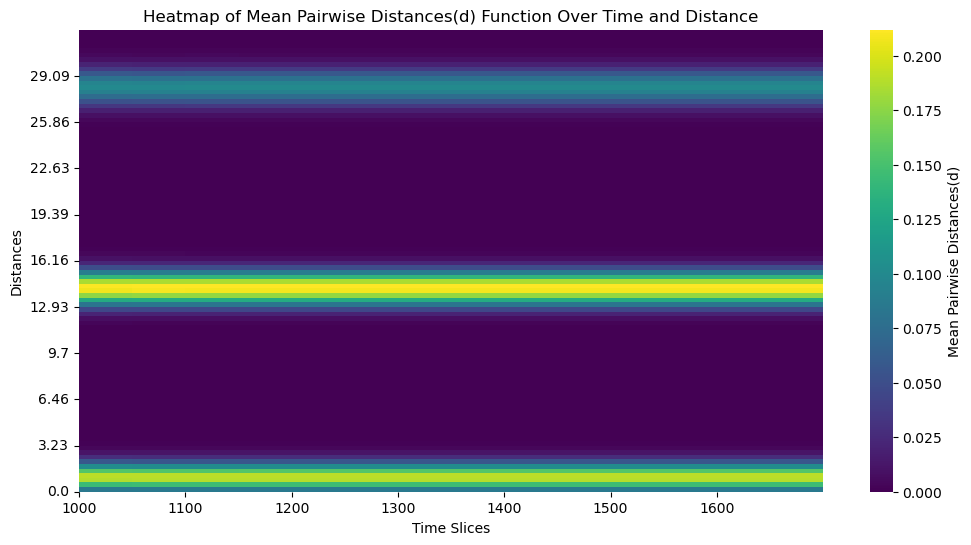

In [112]:
# Run the Monte Carlo simulation to get an ensemble of probable 
# lists of points included in each time slice.
num_iterations = 100
simulations = clustering.mc_samples(points, 
                                    time_slices=time_slices,
                                    num_iterations=num_iterations)

# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

# set consistent pairwise bandwidth (binning of distances)\
use_kde = True
kde_sample_n = 100
pair_bw = 0.05

# Produce pairwise distances to explore clustering structure
pairwise_density, support = clustering.temporal_pairwise(simulations, 
                                                         time_slices, 
                                                         bw=pair_bw, 
                                                         use_kde=use_kde, 
                                                         kde_sample_n=kde_sample_n,
                                                         max_distance=max_distance)

print(pairwise_density.shape)

# Visualize clustering with heatmap
clustering_heatmap(pairwise_density,
                   support,
                   time_slices,
                   result_type='Pairwise Distances')

### CSR Comparison
Now, we will use CSR as the baseline (as previously in this tutorial) to identify the statistically significant modes in the pairwise distance density surface. As you can see below, the overall span of the entire set of points is emphasized in the CSR-based comparison. The disances around 28 units is twice that of the distances between the cluster centres (14 units between successive ones).

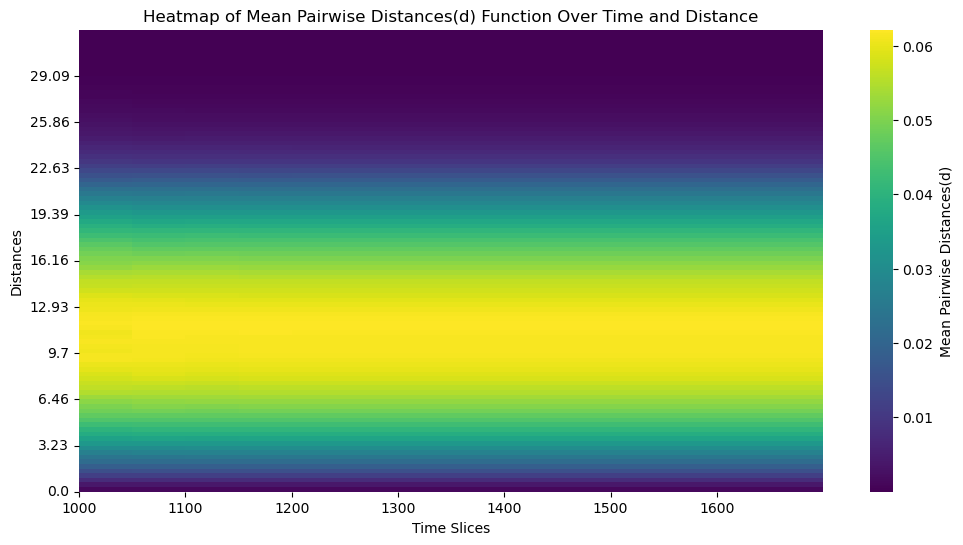

In [113]:
# Get MC iterations for incorporating chronological uncertainty with CSR
csr_simulations = clustering.mc_samples(points, 
                                        time_slices=time_slices, 
                                        num_iterations = num_iterations,
                                        null_model=clustering.csr_sample,
                                        x_min=x_min, 
                                        x_max=x_max, 
                                        y_min=y_min, 
                                        y_max=y_max)

# Calulate the pairwise distances for the CSR sample
csr_pairwise_density, csr_support = clustering.temporal_pairwise(csr_simulations, 
                                                                 time_slices, 
                                                                 bw = pair_bw, 
                                                                 use_kde = use_kde, 
                                                                 kde_sample_n = kde_sample_n,
                                                                 max_distance = max_distance)

# Visualize clustering with heatmap
clustering_heatmap(csr_pairwise_density,
                   csr_support,
                   time_slices,
                   result_type='Pairwise Distances')

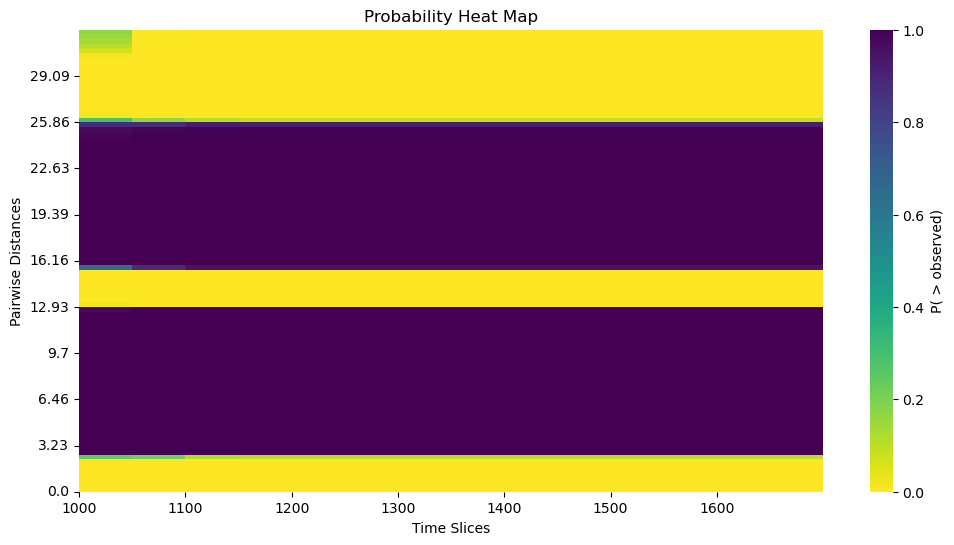

In [114]:
# Calculate the p-values for density differences between the observed points and 
# the simulated CSR baseline per distance and temporal slice
p_diff_array, diff_array = clustering.p_diff(pairwise_density, csr_pairwise_density)

# Plot the heatmap of probabilities
pdiff_heatmap(p_diff_array,
              time_slices,
              csr_support)

### BISE Comparison
Now, we can use the BISE as the basis for comparison. You can see in the plot below that the higher probability pairwise distance region correpsonding to the maximum distance between farthest clusters has been greatly de-emphasized. In effect, the BISE is acting like a high-pass filter, removing the effect of the overall size of the point dataset within the study area (in this case the smallest bounding box).   

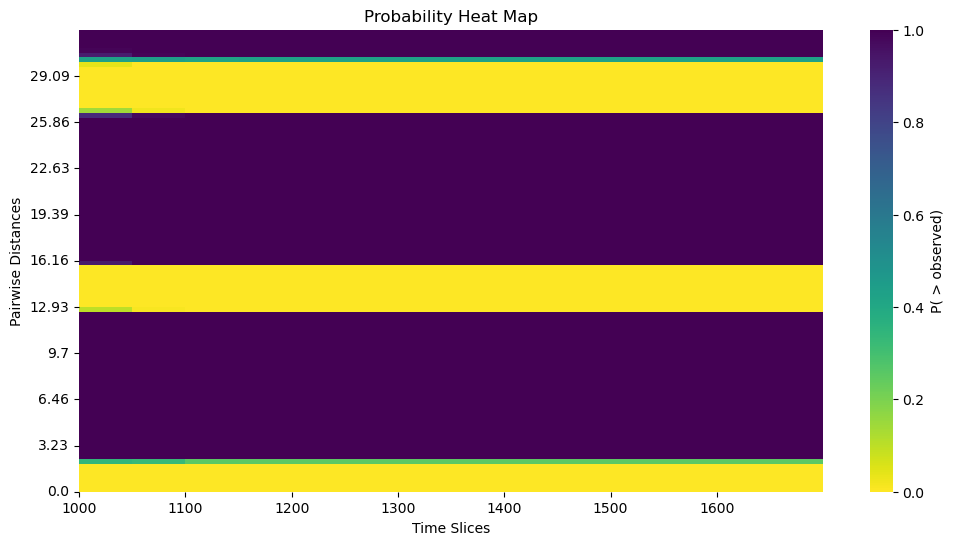

In [115]:
# Get MC iterations for incorporating chronological uncertainty with BISE
bise_simulations = clustering.mc_samples(points, 
                                         time_slices=time_slices, 
                                         num_iterations=num_iterations,
                                         null_model=clustering.bise)

# Calulate the pairwise distances for the LISE sample
bise_pairwise_density, bise_support = clustering.temporal_pairwise(bise_simulations, 
                                                                 time_slices, 
                                                                 bw = pair_bw, 
                                                                 use_kde = use_kde, 
                                                                 kde_sample_n=kde_sample_n,
                                                                 max_distance = max_distance)

# Calculate the p-values for density differences between the observed points and 
# the simulated CSR baseline per distance and temporal slice
p_diff_array, diff_array = clustering.p_diff(pairwise_density, bise_pairwise_density)

# Plot the heatmap of probabilities
pdiff_heatmap(p_diff_array,
              time_slices,
              bise_support)

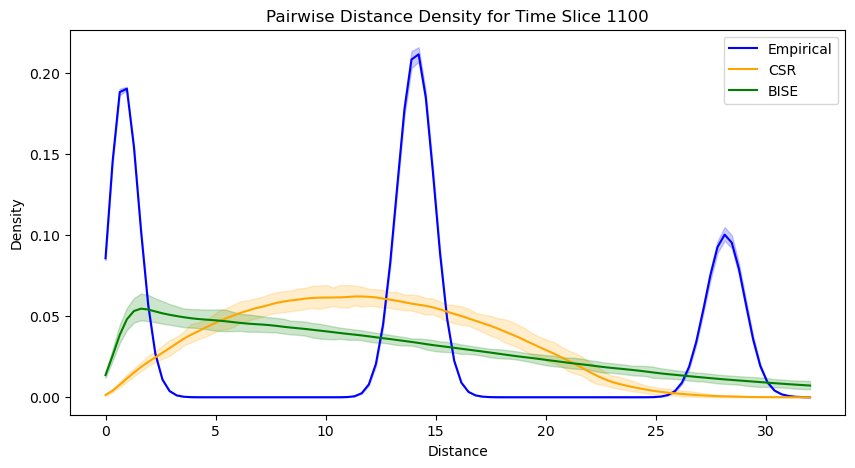

In [116]:
from chronocluster.utils import plot_pdd

time_slice_idx = np.where(time_slices == 1100)[0][0]  # corresponding to time 1100

# List of density arrays
density_arrays = [pairwise_density, csr_pairwise_density, bise_pairwise_density]

# Generate the plot and get the figure and axis objects
fig, ax = plot_pdd(
    time_slices=time_slices,
    time_slice_idx=time_slice_idx,
    support=support,
    density_arrays=density_arrays,
    quantiles=[0.025, 0.975],
    density_names=["Empirical", "CSR", "BISE"],
    colors=["blue", "orange", "green"]
)

# Show the plot
plt.show()

## Kernel Density Estimation (KDE)
Chronocluster provides methods for Kernel Density Estimation (KDE) and for identifying specific clusters in the data. In this section, we use KDE to quantify the spatial distribution of our simulated data, providing a smooth, continuous representation of density that highlights underlying patterns at scales relevant to our analysis. KDE is a powerful, commonly-used tool for exploring how density changes across space continuousely, and it is often used for revealing subtle structure that may not be immediately evident in raw point data alone. It is important to note, though, that KDE is an empirical approximation to the a (presumed) underlying continuous density and is, itself, not a good predictive model. It is highly sensitive to sampling error and, in general in archaeology, cannot account for temporality or chronological uncertainty. The KDE tools in the chronocluster package, however, include support for the Point object and use inclusion probabilities to weight the KDE given a set of points with corresponding uncertain start-/end-distributions, temporality, and a time-slice from a given space-time volume.

### KDE Primer
Kernel Density Estimation (KDE) approximates the underlying density of a spatial dataset at any arbitrary location in a specified spatial field. In a standard Gaussian KDE, the density at each location is estimated based on its distance from all observed points, weighted by a Gaussian (normal) kernel function. This produces a continuous density surface that reflects spatial intensity.

Mathematically, the KDE at a point x is given by:

$$ \hat{f}(x) = \frac{1}{n h} \sum_{i=1}^{n} K\left(\frac{x - x_i}{h}\right) $$

where:
- $ f^​(x) $ is the estimated density at location x,
- $ n $ is the total number of observed points,
- $ h $ is the bandwidth parameter controlling the smoothing scale,
- $ K\left(\frac{x - x_i}{h}\right) $ is the kernel function, typically Gaussian, centered at each observed point $ x_i $​.

For a Gaussian kernel, K is defined as:

$$ K\left(\frac{x - x_i}{h}\right) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{(x - x_i)^2}{2h^2}\right) $$

This formulation calculates the influence of each point $ x_i $ on the density at location $ x $, with closer points having a larger impact due to the kernel’s shape. Adjusting the bandwidth hh tunes the KDE resolution, allowing us to highlight spatial patterns and potential clusters.

### Incorporating Temporal Information with kde_time
The kde_time method in the chronocluster package builds on simple KDE by integrating temporal information through probability weighting. This temporal weighting relies on the in_probs method of the Points class, which calculates each point’s probability of persistence in the space-time volume for a specified time, based on its start and end distributions. By utilizing in_probs, kde_time factors in whether each point is likely to be present within the time-slice of interest, allowing the KDE to reflect temporal dynamics alongside spatial distribution.

In this method, the KDE density at a point $ x $ within a time-slice $ t $ is defined as:

$$ \hat{f}_{\text{time}}(x, t) = \frac{1}{n h} \sum_{i=1}^{n} P_{i}(t) \cdot K\left(\frac{x - x_i}{h}\right) $$

where:

- $ \hat{f}_{\text{time}}(x, t) $ is the density estimate at location xx for time $ t $,
- $ P_i(t) $ is the probability that point $ x_i $​ is present at time $ t_i $, as calculated by in_probs based on the point’s start- and end-distributions.

By referencing the in_probs function within the Points class, kde_time aligns with the chronocluster paradigm, leveraging temporal uncertainty to weight spatial density. This allows us to visualize how clusters may shift over time, capturing temporal trends in density as points appear or fade from the spatial field according to their temporal likelihood.

### Context and Purpose
In the previous tutorial sections, we used pairwise distance distributions to examine the simulated point data for structure and clustering. Here, we can introduce a useful anlaytical concept, the ``characteristic scale(s)''---i.e., the distance(s) at which structure emerges from the point pattern. These scales refer to the statistically significant modes in the pairwise distance densties, which capture the typical distances between points that define spatial relationships in the whole point distribution. Through the BISE-based significance test, we identified these characteristic distances as meaningful peaks within the pairwise distance density function, indicating spatial scales at which clustering may be statistically significant (compared to an informed null expectation).

For KDE analysis, the choice of bandwidth is crucial because it determines the level of detail at which patterns are visualized. In practical applications, bandwidth is often selected using general “rules of thumb,” such as Silverman’s rule or Scott’s rule, which estimate bandwidth based on the overall spread of the data. However, these rules may be too generic for archaeological datasets or spatial data with distinctive, scale-dependent patterns.

In this analysis, we will take a more deliberate approach by basing the KDE bandwidth on the characteristic scale(s) identified earlier. This scale-informed bandwidth allows us to tailor the KDE to highlight clustering and spatial patterns specifically at the scales that were statistically validated through our pairwise distance analysis and BISE testing. By choosing a bandwidth grounded in these characteristic scales, we achieve several key benefits:

- Scientific Rigor: The bandwidth selection is not arbitrary but informed by the data’s spatial structure, leading to more reliable interpretation of clustering.
- Scale-Specific Insight: Using characteristic scales allows us to explore density patterns at meaningful spatial resolutions, focusing on distances where significant clustering is likely, rather than smoothing over important detail.
- Comparability: Employing a data-derived bandwidth makes it easier to compare results across similar datasets or different regions within a study, as the analysis is based on statistically meaningful patterns rather than rule-of-thumb estimates.

This method provides a scientifically grounded approach to exploring spatial density, allowing us to interpret clustering and patterning at scales that are particularly relevant to our dataset. By integrating characteristic scales into our KDE analysis, we can create visualizations that reveal clustering patterns in a way that aligns closely with the statistical structure of the data.

### KDE in Chronocluster
Chronocluster's KDE methods offer flexible options for bandwidth selection, which controls the scale of smoothing applied to the density surface. By adjusting the bandwidth to match our characteristic scale(s), we can tune the KDE to highlight clusters at spatial scales that are most relevant to the patterns we defined with (and then recovered from) the simulated data. The KDE output will serve as the foundation for further steps, such as cluster delineation, quantifying the density at characteristic scales, and pinpointing core areas of interest for later analyses.

In [ ]:
from chronocluster.density import kde_time, custom_kde, kde_peaks

# Define grid resolution and create the 2D grid for KDE evaluation
# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

grid_resolution = 100
x_grid = np.linspace(x_min, x_max, grid_resolution)
y_grid = np.linspace(y_min, y_max, grid_resolution)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
grid = np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T 

In [ ]:
# Set parameters for KDE, including arbitrary time_slice from simulated data
time_slice = time_slices[3]
bandwidth =  1.5

# Calculate KDE for the chosen time slice
kde_values = kde_time(points, time_slice, bandwidth, grid, output_shape=x_mesh.shape, kde_method=custom_kde)

# Plotting
plt.contourf(x_mesh, y_mesh, kde_values, levels=20, cmap='viridis')
plt.colorbar(label="KDE Density")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title(f"KDE for Time Slice {time_slice}")
plt.show()

### Exporting a chronocluster KDE
The `chronocluster` package supports exporting KDEs as GeoTIFF files for use in other programs, like QGIS.

In [ ]:
from chronocluster.data.dataio import kde_to_geotiff

kde_to_geotiff(x_mesh,
               y_mesh, 
               kde_values, 
               epsg_code=4326, 
               output_path="kde_output.tif")

### Peak Identification
It's clearly useful to have a rigourous and pricipled approach to identifying characteristic scales, clustering at those scales, and then to visualize the density of points with a KDE. But, it is also frequently important to identify where the clusters actually are in space.

The peak-finding functionality in chronocluster is designed to offer flexibility and modularity. At the core of this structure is the kde_peaks function, which acts as a high-level wrapper for several peak-finding methods. By allowing the user to select the most appropriate method and customize the peak-finding process, kde_peaks provides a unified interface for detecting peaks in KDE surfaces or point distributions.

#### The `kde_peaks` Wrapper Function
The kde_peaks function serves as a single entry point for identifying peaks across different types of data structures (e.g., KDE grids, raw point distributions) and analysis needs. It takes a range of arguments, including:

- kde_values, x_mesh, y_mesh: Used when analyzing a KDE surface grid, these parameters represent the KDE values and corresponding coordinate grids. These inputs are essential for peak-finding methods like find_peaks and peak_local_max.

- points: A list of Point objects, each representing a point’s x and y coordinates in the dataset. This is used by the gmm_peak_finder and pymc_gmm_peak_finder methods, which operate directly on point distributions rather than KDE surfaces.

- num_peaks: Specifies the maximum number of peaks to identify. This parameter limits the number of clusters or density peaks returned.

- peak_finder: Allows the user to specify the desired peak-finding method. Options include: 
    - scipy.signal.find_peaks
    - skimage.feature.peak_local_max
    - gmm_peak_finder (Gaussian Mixture Model-based)
    - pymc_gmm_peak_finder (Bayesian GMM with temporal weighting)
    - *args and **kwargs: These allow additional parameters to be passed to the specific peak-finding function, making kde_peaks highly customizable.

Within the kde_peaks function, different peak-finding methods are called based on the user’s selection via peak_finder. Here’s how each method is integrated into the pipeline:

- `find_peaks` (from scipy.signal) This function is used to find local maxima in a flattened KDE surface. When find_peaks is selected, kde_peaks first verifies that kde_values, x_mesh, and y_mesh are provided. The function then applies find_peaks to identify peak locations on the KDE grid, extracting the x and y coordinates of the top-ranked peaks.

- `peak_local_max` (from skimage.feature) If peak_local_max is selected, kde_peaks ensures the necessary grid inputs are provided and then calls this function to find local maxima on the 2D KDE surface. The identified peaks are returned as a set of coordinates based on local density maxima.

- `gmm_peak_finder` (Gaussian Mixture Model) This method operates on raw point data rather than a KDE grid, so points must be provided as input. When selected, kde_peaks calls gmm_peak_finder, which applies a Gaussian Mixture Model (GMM) to fit multiple Gaussian components to the points, representing clusters as Gaussian ellipses. The peaks are sorted by their weights (i.e., the significance of each component) and returned as ranked coordinates.

- `pymc_gmm_peak_finder` (Bayesian Gaussian Mixture Model) This option extends the GMM approach with a Bayesian framework, integrating temporal uncertainty. Using PyMC, pymc_gmm_peak_finder fits a Bayesian GMM model to the point distribution, weighting points according to their likelihood of being present in a given time_slice. Parameters like target_scale and target_scale_sd allow further control over component size and variance. This method is particularly useful for archaeological applications where both spatial and temporal dimensions are critical.

Each peak-finding function in the pipeline has its own specific requirements and return structure, providing both deterministic and probabilistic options for peak detection. By wrapping these methods, kde_peaks allows users to seamlessly switch between techniques, customize parameters, and receive results in a consistent format.

#### Scikit-Learn GMM
In addition to standard and widely-used approaches to peak finding, chronocluster implements Gaussian Mixture Models (GMM), sometimes called "Expectation Maximization" in the archaeological GIS literature. To demonstrate the flexibility of the GMM approach, we first explore the gmm_peak_finder function. This method leverages the Scikit-Learn implementation of GMM as a peak-finding tool, a novel solution to identify clusters in spatial data distributions---even when these clusters don’t strictly follow Gaussian shapes.

Typically, GMM is used as a probabilistic model that a mixture of one or more Gaussian-distributions to a given dataset. However, by increasing the number of components (peaks), the GMM can serve as a highly flexible function approximation method, capable of capturing intricate functions and surfaces, including clustering structures. This flexibility allows `gmm_peak_finder` to approximate non-Gaussian clusters by combining multiple Gaussian components, each centered on a local peak.

##### GMM Primer
To really get an intuition for the GMM approach (important for the more advanced Bayesian version provided by chronocluster), we should start with a brief GMM primer. GMMs are a potentially powerful probabilistic tool for clustering data, representing complex distributions as a combination of multiple Gaussian distributions (called "components"). Each Gaussian component has parameters that define its center, spread, and importance within the overall composite distribution.

At its core, a GMM assumes that the data points are drawn from a mixture of several Gaussian distributions, each representing a cluster. A common example would be body mass in a sexually dimorphic population, like chimpanzees, with one sex being on average larger than the other. The total distribution of bodymasses, then, agnostic toward sex would be somewhat bimodal. This total 'mixed sex' distribution could be modelled with a Gaussian mixture model that combines two normal distributions, one for the males and one for the females. 

Each Gaussian component in a GMM is defined by three key parameters:

- Mean ($ \mu $): The center of the component, which represents the peak location in the spatial distribution.
- Covariance ($ \Sigma $): The shape and spread of the component, which defines how dispersed or elongated the cluster is around its center.
- Weight ($ \pi $): The relative importance of each component, where higher weights indicate more significant clusters within the mixture.

Mathematically, the probability density of a point $ x $ in a GMM with $ K $ components is expressed as:

$$ p(x) = \sum_{k=1}^K \pi_k \cdot \mathcal{N}(x \mid \mu_k, \Sigma_k) $$

where:

- $ \pi_k $​ is the weight of the $ k_{th} $ component (with $ \sum_{k=1}^K \pi_k = 1 $),
- $ \mathcal{N}(x \mid \mu_k, \Sigma_k) $ is the probability density function of the Gaussian distribution centered at $ \mu_k $ with covariance ​$ \Sigma_k $.

Each data point’s likelihood is the weighted sum of probabilities under each Gaussian component, and the overall likelihood of the model is the product of these probabilities for all points. By fitting a GMM to the data, we aim to maximize this likelihood, adjusting each component's mean, covariance, and weight to best represent the observed point distribution.

#### GMM for Peak Finding
GMMs are particularly suitable for peak finding in point distributions due to their probabilistic, likelihood-based nature, which makes them adaptable and statistically parsimonious.

**Likelihood Maximization and Parsimony:** When fitting a GMM, we maximize the likelihood of observing the data given the parameters of each Gaussian component. The model finds the most probable arrangement of peaks (up to a specified maximum number of components) that can explain the distribution of points. This likelihood maximization inherently favors parsimonious solutions, effectively balancing model complexity with data fit. Thus, with a specified maximum number of peaks, GMM provides a robust way to capture the dominant clustering patterns without overfitting to noise.

**Component Weights as a Measure of Peak Importance:** The weight $ \pi_k $ of each component represents the proportion of the dataset that falls under the influence of that component. This weight not only provides a measure of each peak's prominence but also enables a principled approach to determining relative peak importance. By exploring the likelihood surface, the Gaussian Mixture Model (GMM) automatically down-weights redundant or overlapping peaks, thus effectively reducing noise and ensuring that only the most statistically meaningful peaks receive higher weights. Importantly, the `max_peaks` parameter can be quite high in theory, as any "excess" components will naturally be assigned lower weights if they do not correspond to distinct and prominent peaks in the data. Additional tools (e.g., model selection by varying the number of peaks) or cumulative peak weights (akin to cumulative variance accounted for in Principle Components Analysis) could also be used to identify the best number of peaks to include.

**Flexibility to Capture Complex Cluster Shapes:** By combining multiple Gaussian components, GMM can approximate non-Gaussian shapes in the data. For instance, an elongated or irregular cluster can be represented as a combination of several Gaussians, allowing GMM to adapt to a wide range of spatial patterns. This flexibility is especially useful in archaeology and spatial analysis, where clusters may not follow simple, circular distributions.


In [ ]:
from chronocluster.density import kde_peaks, gmm_peak_finder

# Set up parameters for GMM peak finding using kde_peaks
num_components = 5  # Set the maximum number of peaks/components expected

# Run kde_peaks with GMM as the peak-finding method
# Assuming coordinates is your dataset of temple locations, passed as Point objects
peaks, weights = kde_peaks(points=points, num_peaks=num_components, peak_finder=gmm_peak_finder)

# Rank peaks by weight for interpretation
ranked_indices = np.argsort(weights)[::-1]  # Sort weights in descending order
ranked_peaks = peaks[ranked_indices]
ranked_weights = weights[ranked_indices]

# Print or plot ranked peaks for interpretation
print("Ranked Peaks (from most to least important):")
for i, (coord, weight) in enumerate(zip(ranked_peaks, ranked_weights), start=1):
    print(f"Rank {i}: Peak at {coord}, Weight = {weight:.4f}")

# Plot KDE with ranked peaks labeled by importance
plt.contourf(x_mesh, y_mesh, kde_values, levels=20, cmap='viridis')
plt.scatter(ranked_peaks[:, 0], ranked_peaks[:, 1], color='red', marker='x', label='GMM Peaks')
for i, (x, y) in enumerate(ranked_peaks[:,:]):
    plt.text(x, y, f"Rank {i+1}", color='white', ha='center')
plt.legend()
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("KDE with GMM Peaks Ranked by Importance")
plt.show()

#### chronocluster Bayesian GMM
The `pymc_gmm_peak_finder` method in chronocluster improves over the standard GMM approach in two key ways. First, it incorporates the characteristic scale directly as a prior for the variance of the Gaussian components, anchoring the analysis in a scale relevant to the data’s spatial structure. Second, it accounts for chronological uncertainty by weighting observations based on temporal inclusion probabilities, allowing the analysis to focus on a specified time slice while respecting uncertainties in the temporal data.

#### Bayesian Advantage
While the standard GMM provides a flexible way to identify clusters or peaks, it lacks mechanisms for handling temporal weighting and chronological uncertainty directly:

1. *No Native Support for Temporality:* Standard GMM does not allow for weighting observations based on their likelihood of inclusion in a particular time slice. This makes it difficult to focus on temporally specific patterns without creating cumbersome workarounds, such as bootstrapping to resample data.

2. *Handling Chronological Uncertainty:* In archaeological data, dates are usually uncertain, which is handled in chronocluster with probabilistic start-/end-distribution class members. By duplicating points based on their inclusion probabilities (again, calculated with a `Point` class method, `in_probs`) for a specific time slice, the Bayesian approach can naturally accommodate these uncertainties in the likelihood estimation.

The Bayesian GMM in Chronocluster overcomes these limitations, providing a more versatile and scientifically grounded framework for analyzing spatial data with temporal dimensions.

#### Key Features of the Bayesian GMM in Chronocluster

1. Incorporation of Characteristic Scale as a Variance Prior

    In the Bayesian GMM approach, the characteristic scale---a statistically significant distance that defines the typical spatial relationships in the data---is used to set a prior for the variance of each Gaussian component. This characteristic scale is derived from previous analyses (such as pairwise distance distributions) and provides a meaningful constraint on the spread of each cluster. By setting this prior, we guide (or even tightly constrain) the model to favor clusters that align with known spatial patterns, ensuring that the estimated clusters are interpretable and relevant.

    Mathematically, we define this prior for the variance of each Gaussian component using a Truncated Normal distribution, centered on the characteristic scale with a specified standard deviation:

    $$ \sigma_k \sim \text{TruncatedNormal}(\mu = \xi, \sigma = \xi_\sigma, l = 0) $$

    where

    $ \xi $ refers to the characteristic scale (statistically significant mode(s) in the pairwise distance density), $\xi_\sigma $ refers to the variability/uncertainty of that characeristic scale, and $ l $ refers to the lower bound of the distribution.

    This prior constrains each component’s spread around the characteristic scale, encouraging the model to fit clusters that reflect real spatial patterns identified in a systematic way.

2. Handling of Chronological Uncertainty Through Temporal Weighting

    The Bayesian GMM approach in Chronocluster addresses chronological uncertainty by leveraging temporal inclusion probabilities, which estimate each point’s likelihood of being present within the time slice of interest. To implement this weighting, we generate a simulated dataset in which points are duplicated in proportion to their inclusion probability, effectively weighting the likelihood calculation.

    For example, if a point has a 0.6 probability of inclusion in the given time slice, it will appear approximately 60% more frequently in the simulated dataset than a point with a 0.1 inclusion probability. This approach lets us approximate a weighted distribution without requiring complex modifications to the GMM’s structure.

    This duplication-based weighting allows the model to incorporate temporal uncertainty and focus on clusters that are likely to be relevant in the specified time slice, without needing to repeatedly sample or bootstrap the data, looping over the whole estimation procedure each time.

    While this may initially appear ad-hoc, the process of duplicating points effectively reweights the likelihood in a way that is statistically coherent.

    *Likelihood Reweighting:* In a typical Bayesian GMM, the likelihood for a dataset of $ n $ points $x_i$ with mixture components $ k $ is given by:

    $$ \mathcal{L}(x_i) = \prod_{i=1}^n \sum_{k=1}^K \pi_k \cdot \mathcal{N}(x_i \mid \mu_k, \Sigma_k) $$

    where $ \pi_k $ is again the weight for component $ k $, and $ \mathcal{N}(x_i \mid \mu_k, \Sigma_k) $ is the Gaussian density for component $ k $ at point $ x_i $.

    *Incorporating Temporal Inclusion Probabilities:* When we duplicate a point $ x_i $ based on its inclusion probability​ $ P_i $ (derived from `in_probs`), we effectively increase the point’s contribution to the overall likelihood by a factor proportional to ​. Each duplication increases the likelihood by:

    $$ \prod_{j=1}^{P_i \cdot N} \sum_{k=1}^K \pi_k \cdot \mathcal{N}(x_i \mid \mu_k, \Sigma_k) $$

    where $P_i \cdot N$ is the effective number of synthetic samples for $ x_i $.

    *Effect on Likelihood Approximation:* By duplicating points in proportion to $ P_i $​, the synthetic dataset approximates the likelihood as if each observation $ x_i $ were weighted by $ P_i $​. The duplication approach effectively inflates the contribution of high-probability points and deflates low-probability points. By doing so, we avoid the complexity of formal statistical weights, and the computational overhead of bootstrapping, while maintaining statistical coherence, as the likelihood now reflects both spatial clustering and temporal relevance.

#### Setting Up the Bayesian GMM in Chronocluster

With these improvements, we can apply the Bayesian GMM as follows:

1. **Specify the Key Parameters** 
- Characteristic Scale: Use this as the prior mean for the Gaussian component variance, aligning each component’s spread with known spatial patterns.

- Inclusion Probabilities: Set up a simulated dataset by duplicating points based on their inclusion probabilities for the selected time slice, providing a temporally weighted dataset. This can be done with the chronocluster function, `synth_sample`.

2. **Fit the Bayesian Model**
- The Bayesian GMM uses the `pymc_gmm_peak_finder` method, which constructs a Dirichlet Process for mixture weights, defining each component’s center, variance, and weight. Given the characteristic scale as a variance prior and the temporally weighted dataset, the model iteratively adjusts parameters to maximize the posterior probability, producing clusters that reflect both spatial and temporal structures.

3. **Interpret the Results**
- Peak Coordinates: The posterior mean of each component’s center indicates the coordinates of a peak, weighted by both spatial density and temporal relevance.

- Component Weights: These weights indicate the relative prominence of each peak within the time slice, allowing us to rank and filter clusters based on significance. The `pymc_gmm_peak_finder` model incorporates a threshold parameter for identifying important components based on weights (defaults to $\frac{1}{w}$). A posterior distribution for each component, $ \delta_k $ is produced that reflects $ w_k - w_{threshold} $. This way, we can easily use credible intervals to identify important peaks where $ P(\delta_k > 0) > 1 - \alpha $ given a p-value-like threshold for $ \alpha $ (e.g., 0.05) or $ HDI_{95}(\delta_k) > 0 $.  

In [ ]:
import pymc as pm
from chronocluster.density import pymc_gmm_peak_finder

# Calculate the spatial extent based on bounding box to constrain the prior for
# the component means (parameter space outside this area is going to be fruitless)
x_min, y_min, x_max, y_max = get_box(points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))
bounding_box_variance = ( max_distance/ 2)**2

# Set maximum number of components to allow in the model
max_components = 8
w_threshold = 1 / max_components # used for idenitifying peak importance

# Priors for spatial scale (variance) based on pairwise distance density analysis
target_scale = 1.5  # This is our target spatial scale for each component
target_scale_sd = 0.3  # Some variation around this value

# time slice (set earlier on, but to jog the memory)
time_slice = time_slices[3]

# Run kde_peaks with GMM as the peak-finding method
# Assuming coordinates is your dataset of temple locations, passed as Point objects
peaks, weights, trace = kde_peaks(points=points, 
                                    num_peaks=max_components, 
                                    peak_finder=pymc_gmm_peak_finder,
                                    time_slice = time_slice,
                                    target_scale = target_scale,
                                    target_scale_sd = target_scale_sd,
                                    w_threshold = w_threshold,
                                    sampler = 'NUTS',
                                    draws = 2000,
                                    tune = 4000,
                                    chains = 1)

#### Significant Peaks
There are at least two obvious ways to leverage GMM to find significant peaks. 

1. Component weight threshold

The first was detailed above and involves using a theshold for the component weights. Any components (clusters) exceeding the threshold (either absolutely or when considering the posterior credible intervals and some significance threshold) would be retained as 'significant' or 'important' given the characteristic scale of the analysis. This can be accomplished in `chronocluster` as follows:

In [ ]:
from chronocluster.density import rank_peaks

importance_hdi = 0.80
summary_df = rank_peaks(trace, significance=importance_hdi, source_param='importance')

# isolate important peaks
# Filter rows where the lower bound of the HDI is greater than importance_threshold
importance_threshold = 0
condition = summary_df[f'{int(importance_hdi * 100)}% HDI (Importance)'].apply(lambda hdi: hdi[0] > importance_threshold)
important_peaks = summary_df[condition] # isloated for plotting below
summary_df

Exporting the peaks as a GIS file with the `summary_df` as an associated attribute table:

In [ ]:
pts_df_to_gis(summary_df,
              epsg_code=4326,
              output_path="cluster_centres.gpkg", 
              file_format="GPKG")

In [ ]:
# Plot KDE density surface
plt.contourf(x_mesh, y_mesh, kde_values, levels=20, cmap='viridis')

# Extract the X and Y coordinates from the Coordinates column for plotting
x_coords = important_peaks['Coordinates'].apply(lambda coord: coord[0])
y_coords = important_peaks['Coordinates'].apply(lambda coord: coord[1])

# Plot the GMM peaks with red 'x' markers
plt.scatter(x_coords, y_coords, color='red', marker='x', label='GMM Peaks')

# Annotate each component with its rank
for i, (x, y, rank) in enumerate(zip(x_coords, y_coords, important_peaks['Rank']), start=1):
    plt.text(x, y, f"Rank {rank}", color='white', ha='center', va='center', fontsize=8)

# Add legend, labels, and title
plt.legend()
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("KDE with GMM Peaks Ranked by Importance")
plt.show()

2. Cumulative Sum of Weights

The cumulative sum of weights approach focuses on capturing the overall density "explained" by the GMM components. By summing the weights in descending order, we can identify the subset of peaks that account for a significant portion (e.g., 90%) of the data density. This is analogous to the "variance explained" criterion in PCA, providing a flexible way to balance sensitivity and specificity.

GMM weights are probabilistic and sum to 1, allowing us to interpret them as the relative contributions of components to the overall density. By considering the cumulative sum of weights, we can prioritize the most important peaks while downweighting or excluding minor (less interesting) components.

Steps:

- Sort Components by Weight:
    - Order the GMM components in descending order of their weights.

- Compute the Cumulative Sum:
    - Calculate the cumulative sum of weights (Cumulativew=∑i=1NwiCumulativew​=∑i=1N​wi​).

- Set a Cumulative Threshold:
    - Determine a threshold (e.g., 95%) for the total density to be captured.
        Select components whose cumulative sum meets or exceeds this threshold.

- Interpret Results:
    - Components included in the cumulative sum up to the threshold represent the most significant peaks.
    - Remaining components can be considered less important or noise.

In [ ]:
summary_df = rank_peaks(trace, significance=importance_hdi, source_param='w')
summary_df['W_Cumulative'] = summary_df['W'].cumsum()
summary_df


In this case, the first three components would be considered the most important by both approaches. With the cumulative approach, the first component to exceed the cumulative threshold is the last component considered important (in this case, it would be the first three components, concordant with the results from the previous threshold approach).

#### MCMC Sampling Considerations
The Bayesian GMM can be a powerful technique for identifying peaks and provides the flexibility of including both the characteristic scale and temporal uncertainty, but it comes at the cost of having to deal with Markov-Chain Monte Carlo (MCMC) tools, diagnostics, and computational challenges.

One important consideration is *convergnce*. Convergence refers to the point at which the MCMC chain(s) have thoroughly explored the parameter space and stabilized around a posterior distribution. In other words, when the sampling process has reached a stationary distribution that accurately reflects the underlying posterior, we can be confident in the results. A typical Bayesian analysis nowadays frequently involves using multiple chains to improve and diagnosis convergence (multiple MCMC simulations with different starting parameters that ideally lead to the same conclusions, but explore the potential parameter space(s) more thoroughly and quickly). In PyMC, it's possible to set a parameter, `chains`, to use multiple chains and automatically run some convergence checks and then combine the chains for efficient posterior inference. This parameter can be passed through to the PyMC model from `kde_peaks` by including it in the function call as a named parameter---it gets passed through with `**kwargs` to PyMCs `sample` method inside the model context under the hood.

But, with a GMM, there's a phenomenon called 'label switching' that can lead to poor convergence and multimodal posteriors if we use multiple chains. This occurs because the components in a mixture model aren’t inherently ordered. Each chain, in principle, can assign different labels to the same underlying cluster (in one run, the model calls a given cluster 'component[0]' and in another run the same cluster is by chance called 'component[1]', even though the labels refer to the same underlying object), resulting in posterior distributions that appear multimodal when they’re actually capturing the same clusters with inconsistent labels across chains.

So, instead, I recommend using a single chain for a longer time (pass the `**kwargs` `draws = N` where `N` is some large integer and `chains = 1` in the `kde_peaks` function call). By doing this, you avoid the complications of label-switching, as there’s no need for the MCMC sampler to align labels across chains. Of course, this approach isn’t without trade-offs. Running multiple chains allows for certain convergence diagnostics, like the Gelman-Rubin statistic, which measures consistency across chains. With a single chain, you lose that particular diagnostic. Instead, you’ll need to rely on tools like the Geweke diagnostic, which compares different segments of a single chain to check for convergence, or just inspect the trace plots to verify that the chain has stabilized.

Another downside to a single-chain approach is the inability to parallelize. When you’re working with large datasets, the ability to run multiple chains simultaneously can speed up sampling considerably. With one chain, you’re limited to sequential sampling, which may lead to longer runtimes depending on the complexity of the data and model.

For most practical purposes, though, sticking with one chain is the cleaner approach. If you do need to use multiple chains and find that label switching has occurred, there are ad hoc methods to try aligning the clusters afterwards. However, these are often complicated and prone to introducing their own issues. Generally, running a single, longer chain will be better, even if it means giving up some parallelization and diagnostic options.

Some standard PyMC related methods for plotting and checking posterior chains and densities are as follows:

In [ ]:
# Set the number of components to display
N = 3  # Adjust N to control the number of components plotted, here using 3 for demonstration

# Dynamically construct variable names for the first N components
var_names_for_trace = ['w', 'means']  # Always include 'w' and 'means'
var_names_for_trace += [f'chol_{i}' for i in range(N)]  # Add Cholesky variables for the first N components

var_names_for_density = ['w', 'means']  # Always include 'w' and 'means'
var_names_for_density += [f'chol_{i}_stds' for i in range(N)]  # Add std variables for the first N components

# Plot trace for selected variables
az.plot_trace(trace, var_names=var_names_for_trace, compact=True)
plt.show()

# Plot posterior density for selected variables
az.plot_posterior(trace, var_names=var_names_for_density)
plt.show()


And, then, to summarize the posteriors:

In [ ]:
# Summary to see mean cluster coordinate values and credible intervals, for example
az.summary(trace, var_names=["means"])

## Radial Density and KDE
Once important peaks have been identified, there is more we can do with them. Imagine a situation where we are investigating archaeological settlement patterns and where a prominent feature---such as a settlement or natural resource---forms a focal point. In such contexts, it can be informative to characterize how point density changes with increasing distance from this central feature. Geographers, especially Urban Geographers, describe these patterns with radial density profiles, which offer a way to measure and visualize how density decreases or increases radially outward from a given point. For example, in a cityscape, we might expect a central peak of density representing the urban core, with density gradually decreasing as we move outward.

### Defining Radial Density
Radial density profiles estimate the density of points within circular bands (or "rings") at increasing distances from a central point. Imagine a series of concentric rings around a peak---each ring represents a distance from the center, and within each ring, we measure how many points exist per unit area. This approach captures how density is organized around a focal point, allowing for comparisons across distances that could reveal patterns like clustering, uniform spread, or gradients.

#### Estimating Radial Density Using Radial Bins
The traditional approach to estimating radial density involves dividing the area around the peak into a series of radial bins, each defined by a specific distance from the central point. For each bin, we calculate the density as the number of points within the bin divided by its area, giving a sense of how dense the region is at that distance. This total density within the ring is actually also the average density, which is a much more helpful way to interpret the resulting profile that tracks changes in this metric with increasing distance (radii) from the central point.

For intuition-building, consider a simple case: dividing each radial bin into smaller, equally-sized segments (like slicing each ring into thin pie slices). If we calculate the density within each segment, then average these segment densities, we approach the overall density of the full ring. It's easy to see this when we consider that densities are simple ratios and we are holding the magnitude of the denominator (the size of the slices) constant.

Consider a radial bin at some distance $ r $ from a center point, with an outer radius $ r\Delta r $. The area $ A $ of this ring (bin) is:

$$ A = \pi(r + \Delta r)^2 - r^2 = \pi\Delta r \cdot (2r + \Delta r) $$

Now, imagine that we divide this radial bin into $ n $ equally-sized segments, like thin pie slices, where each $i^{th}$ segment has an area $A_i$ and contains $p_i$ points. The density $ d_i $ within each segment is simply:

$$ d_i = \frac{p_i}{A_i} $$

If we sum the points in all segments and then average their densities, $ \hat{A} $ , we get:

$$ \hat{A} = \frac{a}{n} \sum_{i=1}^n d_i = \frac{a}{n} \sum_{i=1}^n \frac{p_i}{A_i}$$

Since each segment’s area $ A_i $ is the same by construction, we can factor it out and rewrite this expression as:

$$ \hat{A} \approx A = \frac{\sum_{i=1}^n p_i}{\sum_{i=1}^n A_i} = \frac{\text{Total Points}}{\text{Total Area}} $$

This is just the total density within the entire radial bin.

As $ n \to \infty $, the segments become infinitely thin, and this average density converges to the density calculated over the entire ring area. This shows that the radial density within a bin is effectively an aggregate of densities around the ring at that distance. In other words, when we calculate radial density by averaging over smaller segments, we are capturing the density around the ring in a way that approaches the total density for that radius as our segments get infinitely thin. IT also demonstrates that we can interpret the total density within a radial bin as the average density around the ring.

#### Introducing Radial KDE as a Continuous Extension
The binning approach described above is effective but inherently discrete, as it relies on fixed-width radial bins. A natural extension to this method is Radial KDE (Kernel Density Estimation), which allows us to estimate density smoothly and continuously at any given radius from the peak. Radial KDE takes the continuous KDE surface, integrates it along a ring at the specified radius, and produces a density estimate. This approach smooths out local variations that might emerge from binning, giving a clearer view of the general density trend across distances. Importantly, it's conceptually similar to the bin-segment averaging explained above in that the resulting single value per ring ammounts to an average (continuous) density estimate and this average gets better (more accurate) the higher our sampling density on the ring is.

Slightly more formally, for Radial KDE, we start by defining a sequence of concentric rings at increasing radii, $\{ r_1, r_2, … , r_n ​\}$​, from a central point (typically one of the identified peaks from before). For each radius $ r_i $​, we sample the continuous KDE surface along the circumference of the ring defined by $ r_i $ to obtain an average density at that distance.

1. Defining the Ring: At a given radius $ r $ from the central point, the circumference of the ring is $ C(r) = 2\pi r $.

2. Sampling the KDE Surface: Sample points along the circumference of the ring at $ k $ equal angular intervals, say $ \{ \theta_1, \theta_2, ..., \theta_k \} $ ​, where $ \theta_j = \frac{2\pi rj}{k} $ for $ j = 1, 2, …, k $. Each sample point on the ring then has coordinates:

    $ (x_j, y_j) = (x_\theta + r cos⁡(\theta_j), y\theta + r sin⁡(\theta_j)) $

    where $ (x_\theta, y_\theta) (x_\theta​, y_\theta​) $ is the central point (the peak) and $ r $ is the radius of the ring.

3. Evaluating the KDE at Each Sample Point: For each point $ (x_j, y_j) $ on the ring, we evaluate the KDE surface to get a density estimate $ KDE(x_j, y_j) $.
    
3. Averaging the Densities: The density estimate for the ring at radius $ r $ is the average of the KDE values around the ring:

    $ KDE_{rad}(r) = \frac{1}{k} \sum_{j=1}^k KDE(x_j, y_j) $

    where $ k $ is the number of sample points along the ring. The more points we sample (i.e., the larger $ k $), the closer this estimate will be to the true density profile around the ring.
    
4. Constructing the Radial KDE Profile: By repeating this process for each radius $ r_i $ in our sequence $ \{ r_1, r_2, ... , r_n \} $, we construct a radial density profile. This profile is a smooth function of distance from the central peak, providing a continuous view of how density changes with distance.

Radial KDE has another advantage when used with the chronocluster package: when applied to a KDE surface that has already been weighted by temporal probabilities (such as inclusion probabilities from time-sliced KDEs), it implicitly incorporates chronological uncertainty. This unified profile provides a more robust view of density trends as they would appear over time in archaeological research.

### Radial KDE in chronocluster
With all of that in mind, there are functions in the chronocluster package for producing radial KDEs and radial densities. The two are `radial_density` and `radial_kde`. The latter is the primary tool that uses the chronocluster paradigm since it calls the previously described functions for producing a KDE given the characteristic scale(s) identified and the time slice in a STV for which the KDE profile is desired.

We can begin by simply calling `radial_kde` as follows, passing in one of the important peaks contained in `summary_df` that was identified with the `kde_peaks` method:

In [ ]:
from chronocluster.density import radial_kde
from scipy.stats import halfnorm

# Define parameters
center = summary_df.iloc[0]['Coordinates']
radii = np.arange(0.01, 5, 0.1)  # Radii from 500 to 5000 meters
point_density = 0.01  # 0.01 points per meter along each ring
time_slice = time_slices[3]
bandwidth = 1.5

# Compute radial KDE profile
radial_profile = radial_kde(points, time_slice, bandwidth, center, radii, point_density)

# Scale the radial profile to max = 1
scaled_radial_profile = radial_profile / np.max(radial_profile)

# Compute and scale the half-normal density
half_normal_density = halfnorm.pdf(radii, scale = target_scale)
scaled_half_normal_density = half_normal_density / np.max(half_normal_density)

# Plot scaled radial profile and scaled half-normal density
plt.plot(radii, scaled_radial_profile, marker='o', label='Radial Density (Scaled KDE)')
plt.plot(radii, scaled_half_normal_density, linestyle='--', color='orange', label='Half-Normal (Scaled)')
plt.xlabel("Radius (meters)")
plt.ylabel("Density (Scaled)")
plt.title("Radial Density Profile vs. Half-Normal Distribution")
plt.legend()
plt.show()

As anticipated, the radial KDE looks like the profile of a half-normal density. This means that the radial KDE function is performing as expected and we have identified a valid peak in the density that corresponds to the simulated data parameters. The standard deviation also looks approximately correct, at around 1-1.5 (the half-normal density in the plot has a standard deviation of 1.5 for comparison), which is the standard deviation of the simulated clusters and the characteristic scale identified in the pairwise distance density analysis.